<a href="https://colab.research.google.com/github/michelleaeh/ADissertation/blob/master/05MScCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** MSc in Robotics and Intelligent Systems Dissertation

**Author:** Michelle Alejandra Espinosa Hernandez

**Student registration number:** 1900964

**Student PRID:** ESPIN62803

**Date:** September 2020 

**Purpose:** Obtain classification accuracy among different types of sensors and different data processing steps

# **Data description**

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.

Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.

The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL

If you use this dataset please cite the following papers:

@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}

@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns

**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM


# **Variable definition**

In [1]:
numreps=5      # Number of epochs per word
num_trials=10  # Number of runs of cross validation


# **1. Preparation of data**

**1.1. Start up and initialization of variables**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import random
import scipy as sp
import time
import warnings

from collections import Counter
from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Start timer
starttime = time.time()

# Eliminate warnings
warnings.filterwarnings("ignore")

# Extract all files from zip
with ZipFile("/content/2MyoASL.zip", 'r') as zip:
  zip.extractall()

# Division of sensors
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
     'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
colnames=emg[:8]+acc[:3]+gyro[:3]+ori[:3]+emg[8:]+acc[3:]+gyro[3:]+ori[3:]

# Words
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']

# Generation of matrices
### Combinations of sensors (E=emg=3, A=acc=5, G=gyro=7, O=ori=11)
comb=['E', 'A', 'G', 'O', 'EA', 'EG', 'EO', 'AG', 'AO', 'GO', 'EAG', 'EAO', 'EGO', 'AGO', 'EAGO'] 
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155] 
### Combinations of steps (N=Normalization=3, S=Standardization=5, B=Butterworth=7, P=PCA=11, V=SVM=13)
nsteps=['V', 'NV', 'SV', 'BV', 'PV', 'NBV', 'NPV', 'SBV', 'SPV', 'BPV', 'NBPV', 'SBPV'] 
steps=[13, 39, 65, 91, 143, 273, 429, 455, 715, 1001, 3003, 5005] 
### Placeholders
fresults=np.zeros((len(steps),len(products)))
params=np.zeros((len(steps),len(products)))
headers=np.empty(1701, dtype=object)
lengths=np.zeros(849, dtype=int)
repsum=np.zeros(37,dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)
fn=np.arange(1701)
matrix=np.zeros(1)
stanproducts=[]
normproducts=[]
regproducts=[]
cmatrix=[]

# Initiation of counters
wordnum=-1
counter=-1
rownum=-1
start=0
num=0
n=0

**1.2. Combine all files**

In [3]:
for w in words:
  repcount=0
  wordnum+=1
  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'
    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      trial.reset_index(drop=True)
      
      # Assign word number to each row and make data horizontal
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

  reps[wordnum]=repcount
  if wordnum>0:
    repsum[wordnum]=reps[wordnum-1]+repsum[wordnum-1]
    repsum[36]=849

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
matrix=pd.concat([matrix['Word'],matrix[emg],matrix[acc],matrix[gyro],matrix[ori]],axis=1)
exec("matrix.to_csv(path_or_buf='/content/complete_matrix_'+str(numreps)+'.csv')")
print('Reps of each word:',reps)
print('Cummulative reps:',repsum)

Reps of each word: [19 24 32 20 24 20 19 31 24 29 20 21 23 33 34 18 27 24 35 19 17 34 30 19
 22 21 23 27 27  4 20 19 20 20 21 29]
Cummulative reps: [  0  19  43  75  95 119 139 158 189 213 242 262 283 306 339 373 391 418
 442 477 496 513 547 577 596 618 639 662 689 716 720 740 759 779 799 820
 849]


**1.3. Calculate mean and standard deviation of each sensor and each file**

In [4]:
# Average and standard deviation of each sensor in each file
for s in colnames:
  avg=matrix[s].mean(axis=1)
  sd=matrix[s].std(axis=1)
  sensor=pd.concat([avg.rename(s+': Mean_'),sd.rename('St. dev.')], axis=1)
  if s=='EMG0L':
    asd=sensor
  else:
    asd=pd.concat([asd, sensor], axis=1)
print('Average and standard deviation of each sensor per file')
print(asd)

# Average and standard deviation of each file
avg=matrix.mean(axis=1)
sd=matrix.std(axis=1)
print('Average and standard deviation of each file')
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

Average and standard deviation of each sensor per file
     EMG0L: Mean_   St. dev.  EMG1L: Mean_  ...   St. dev.  OYR: Mean_   St. dev.
0           -2.32   8.664825         -0.80  ...  28.427609       86.70  10.529356
1           -1.80   9.544739         -4.08  ...  27.821010       85.68   6.579002
2           -3.16  13.085839         -2.32  ...  30.345736       91.88  17.358924
3           -0.82  10.123099         -3.16  ...  29.645002       88.46  12.969682
4           -0.50   6.516071          2.76  ...  13.237239      116.58  18.099600
..            ...        ...           ...  ...        ...         ...        ...
844          0.56   7.754288          0.22  ...  17.236281      104.76   7.528341
845         -1.74   6.520955         -1.20  ...  21.772891       69.66  85.251036
846          1.02   7.731436          0.46  ...  22.707735       56.76  79.408415
847          0.06   5.582078          2.36  ...  23.650422       71.62  84.238701
848         -2.22   7.434860         -1.62 

Mean   St. dev.
0    15.256437  46.545832
1    14.220110  47.316822
2    15.441784  45.614456
3    13.651092  47.038916
4    15.063294  49.105612
..         ...        ...
844  13.167964  41.642351
845  13.815314  42.880121
846  12.970618  42.725653
847  13.852317  43.758631
848  13.144035  44.761750

[849 rows x 2 columns]

# **2. Data adjustement**

**2.1. Establish equal number of epochs per word**

In [5]:
for i in range(len(reps)-1,-1,-1):
  if reps[i]<numreps:
    for r in range(len(matrix)-1,-1,-1):
      if int(matrix.iloc[r]['Word'])==i:
        matrix=matrix.drop(r)
  elif reps[i]>numreps:
    elim=random.sample(range(repsum[i],repsum[i+1]),reps[i]-numreps)
    matrix=matrix.drop(elim)

exec("matrix.to_csv(path_or_buf='/content/equal_matrix_'+str(numreps)+'.csv')")

**2.2. Create sensor combinatory matrices: unaltered, normalized, and standardized**

In [6]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  fnword=[]
  fsword=[]
  m=matrix.copy()
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word']   # Features

  # Create column of words instead of numbers
  wordcol=np.empty(len(m), dtype=object)
  z=0
  wcol=[int(i) for i in m['Word'].values]
  for f in wcol:
    wordcol[z]=words[f]
    z+=1
  wordcol=np.asmatrix(wordcol)
  regular=np.concatenate((np.transpose(wordcol),np.copy(m.iloc[:,1:])),axis=1)
  inputmatrix=pd.DataFrame(regular,columns=m.columns).dropna(axis=1)
  regproducts.append(inputmatrix)

  for pr in range(len(inputmatrix)):
    nemg=[]
    nacc=[]
    ngyro=[]
    nori=[]
    norm=[]
    semg=[]
    sacc=[]
    sgyro=[]
    sori=[]
    stan=[]
    if emg[0] in inputmatrix:
      in_emg=inputmatrix.iloc[pr][emg]
      nemg=(in_emg-in_emg.min())/(in_emg.max()-in_emg.min())
      is_emg=inputmatrix.iloc[pr][emg].values
      is_emg=is_emg[np.newaxis]
      semg=StandardScaler().fit_transform(np.transpose(is_emg))
      semg=semg.reshape(-1)
    if acc[0] in inputmatrix:
      in_acc=inputmatrix.iloc[pr][acc]
      nacc=(in_acc-in_acc.min())/(in_acc.max()-in_acc.min())
      is_acc=inputmatrix.iloc[pr][acc].values
      is_acc=is_acc[np.newaxis]
      sacc=StandardScaler().fit_transform(np.transpose(is_acc))
      sacc=sacc.reshape(-1)
    if gyro[0] in inputmatrix:
      in_gyro=inputmatrix.iloc[pr][gyro]
      ngyro=(in_gyro-in_gyro.min())/(in_gyro.max()-in_gyro.min())
      is_gyro=inputmatrix.iloc[pr][gyro].values
      is_gyro=is_gyro[np.newaxis]
      sgyro=StandardScaler().fit_transform(np.transpose(is_gyro))
      sgyro=sgyro.reshape(-1)
    if ori[0] in inputmatrix:
      in_ori=inputmatrix.iloc[pr][ori]
      nori=(in_ori-in_ori.min())/(in_ori.max()-in_ori.min())
      is_ori=inputmatrix.iloc[pr][ori].values
      is_ori=is_ori[np.newaxis]
      sori=StandardScaler().fit_transform(np.transpose(is_ori))
      sori=sori.reshape(-1)
    
    ## Normalize each type of sensor per sample between 0 and 1
    norm=np.concatenate((np.transpose(nemg),np.transpose(nacc),np.transpose(ngyro),np.transpose(nori)))
    norm=norm[np.newaxis]
    fnword=np.append(fnword,norm)
    fnword=fnword[np.newaxis]
    
    ## Standardize each type of sensor with mean=0 and deviation=1
    stan=np.concatenate((np.transpose(semg),np.transpose(sacc),np.transpose(sgyro),np.transpose(sori)))
    stan=stan[np.newaxis]
    fsword=np.append(fsword,stan)
    fsword=fsword[np.newaxis]

  nmx=np.reshape(fnword,(len(inputmatrix),len(inputmatrix.columns)-1))
  norm_matrix=np.concatenate((np.transpose(wordcol),nmx),axis=1) 
  norm_matrix=pd.DataFrame(norm_matrix,columns=inputmatrix.columns).dropna(axis=1)
  normproducts.append(norm_matrix)
  exec("norm_matrix.to_csv(path_or_buf='/content/norm_matrix_'+str(numreps)+'.'+str(v)+'.csv')")

  smx=np.reshape(fsword,(len(inputmatrix),len(inputmatrix.columns)-1))
  stan_matrix=np.concatenate((np.transpose(wordcol),smx),axis=1) 
  stan_matrix=pd.DataFrame(stan_matrix,columns=inputmatrix.columns).dropna(axis=1)
  stanproducts.append(stan_matrix)
  exec("stan_matrix.to_csv(path_or_buf='/content/stan_matrix_'+str(numreps)+'.'+str(v)+'.csv')")


# **3. Definition of functions for steps**

**3.1. Split data into train and test sets**

In [7]:
def datasplit(inmatrix_p):
    x = inmatrix_p.iloc[:, inmatrix_p.columns!='Word']   # Features
    y = inmatrix_p.loc[:,'Word']                         # Target
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x, y, test_size=0.3)
    return x_train_p, x_test_p, y_train_p, y_test_p

**3.2. Butterworth**

In [8]:
def butterworth(inmatrix_b):
  fs_nyq=50/2
  b, a = sp.signal.butter(8, 20/fs_nyq, btype='highpass', fs=fs_nyq)
  if emg[0] in inmatrix_b:
    for r in range(len(inmatrix_b)):
      in_emg=inmatrix_b.iloc[r][emg].values
      emg_filtered = sp.signal.lfilter(b, a, in_emg)
      emg_filtered=emg_filtered[np.newaxis]
      inmatrix_b.iloc[r,1:len(np.transpose(emg_filtered))+1]=emg_filtered
  return inmatrix_b

**3.3. PCA**

In [9]:
def pca(x_train_c, x_test_c, y_train_c, y_test_c):
  #pca = PCA(n_components=min(len(x_train_c), len(y_train_c)))
  pca = PCA(n_components=0.9, svd_solver='full')
  pca.fit(x_train_c)
  x_t_train_pca = pca.transform(x_train_c)
  print(x_train_c)
  print(x_t_train_pca.size)
  x_t_test_pca = pca.transform(x_test_c)
  return x_train_c, x_test_c, y_train_c, y_test_c, x_t_train_pca, x_t_test_pca

**3.4. SVM with Grid Search**

In [10]:
def svm(x_train_s, x_test_s, y_train_s, y_test_s, x_t_train_s, x_t_test_s,combo):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100, 1000]}
    svc = SVC(max_iter=1000)
    nested_scores=np.zeros(num_trials)
    for t in range(num_trials):
      inner_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      outer_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      #clf=GridSearchCV(svc,parameters,scoring='accuracy',n_jobs=1,cv=outer_cv)
      clf=svc
      clf.fit(x_t_train_s, y_train_s)
      nested_scores=cross_val_score(clf,x_t_test_s,y_test_s,cv=outer_cv)
      nested_scores[i]=nested_scores.mean()
    y_pred=clf.predict(x_t_test_s)
    
    # Confusion matrix
    plot_confusion_matrix(clf, x_t_test_s, y_test_s, cmap=plt.cm.Blues)
    plt.title(combo)
    plt.show()

    #bestpar=clf.best_params_
    accuracy=nested_scores.mean()
    svmresult=classification_report(y_test_s, y_pred)
    #return svmresult,accuracy, bestpar
    return svmresult,accuracy

# **4. Main code**

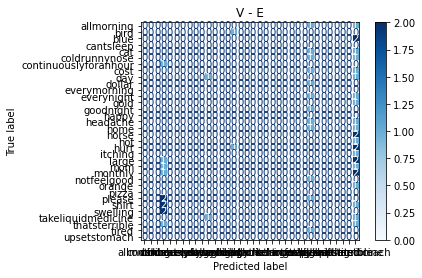

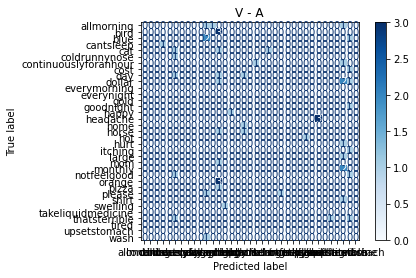

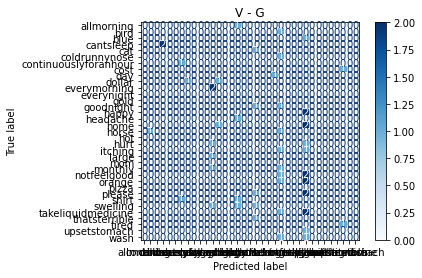

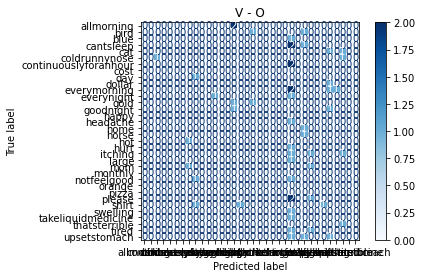

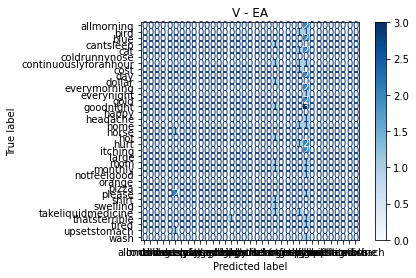

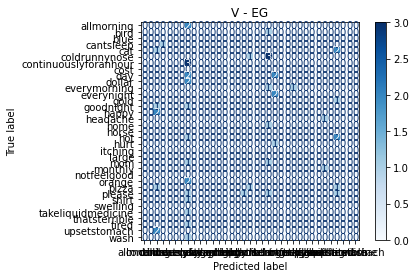

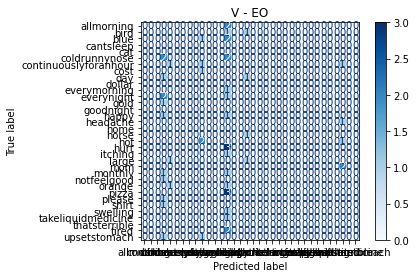

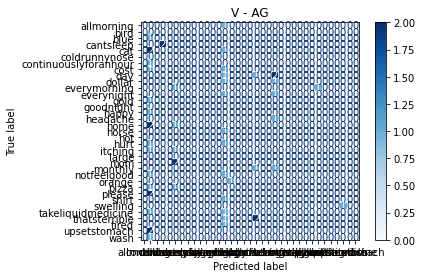

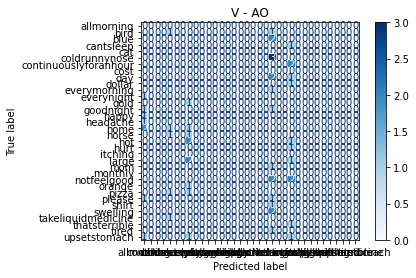

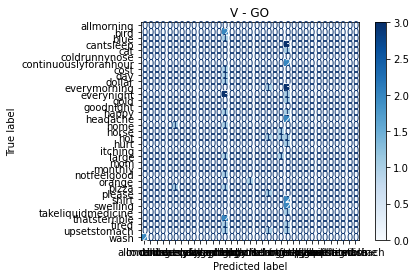

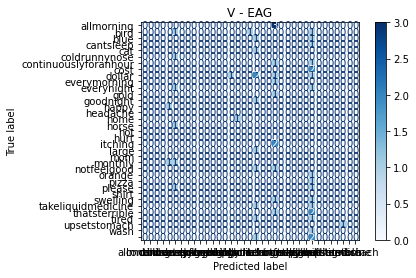

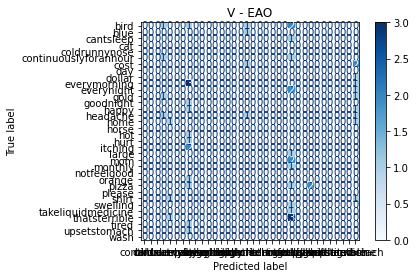

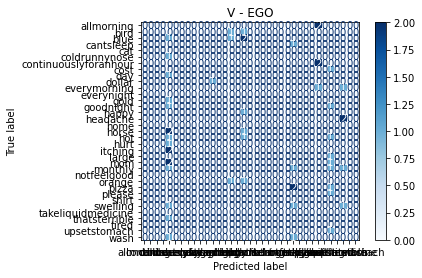

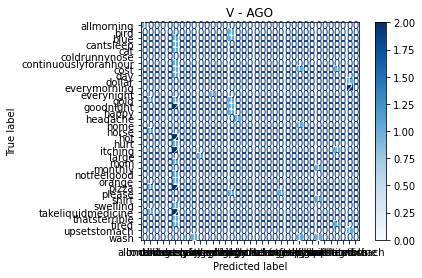

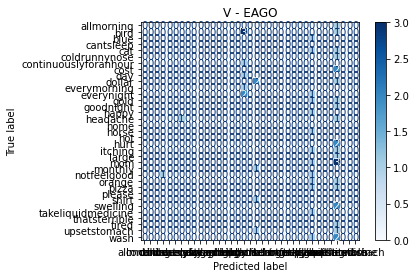

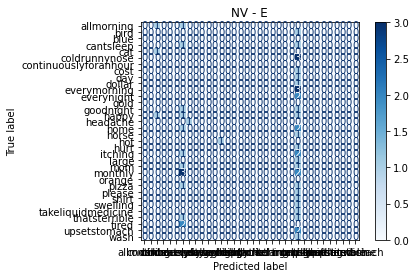

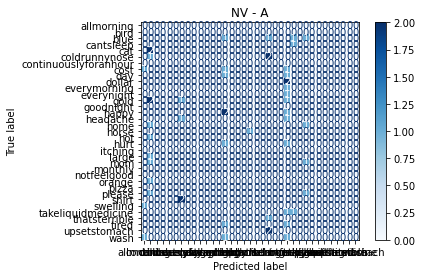

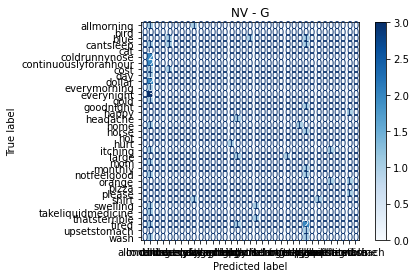

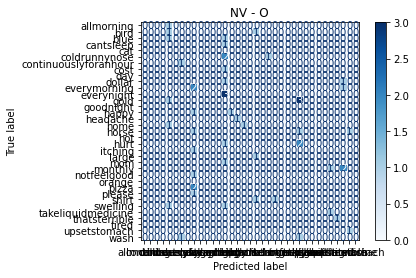

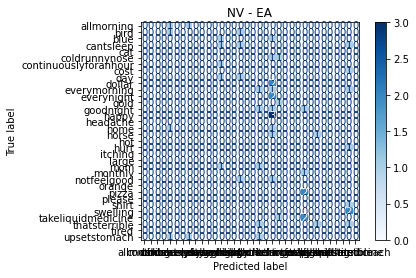

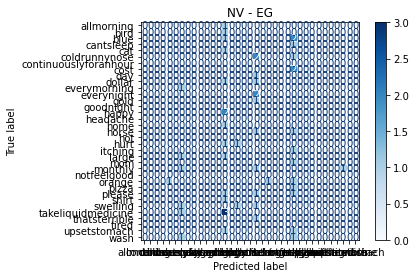

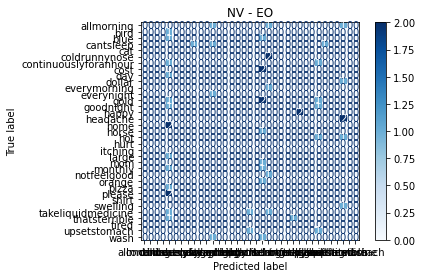

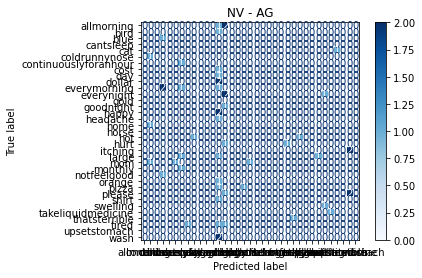

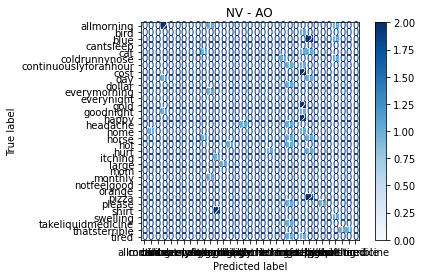

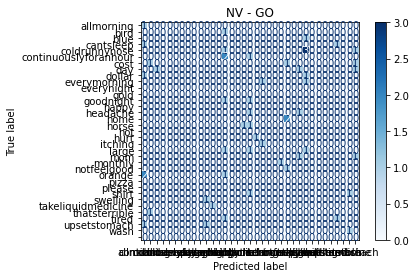

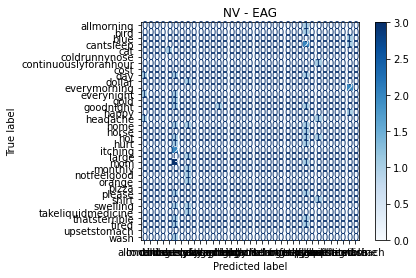

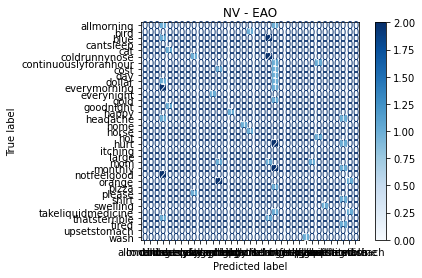

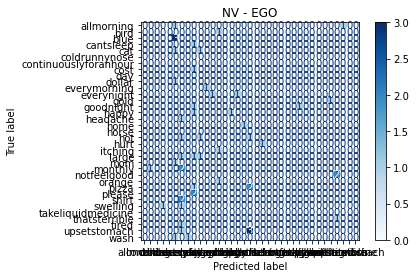

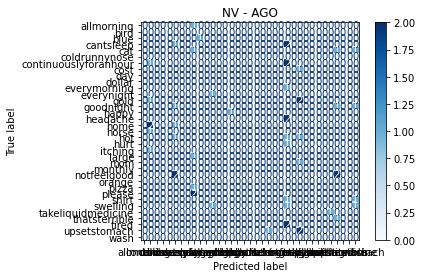

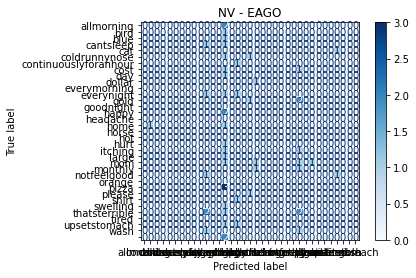

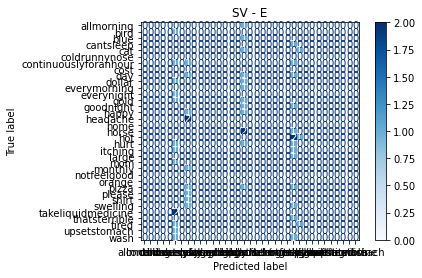

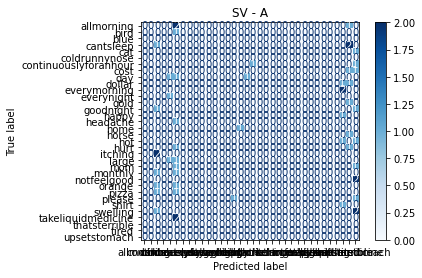

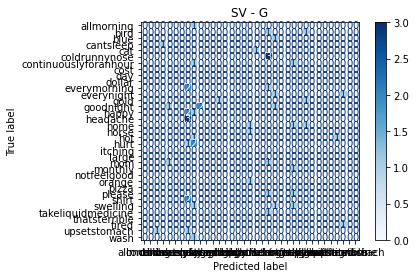

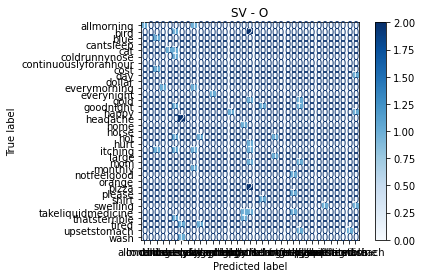

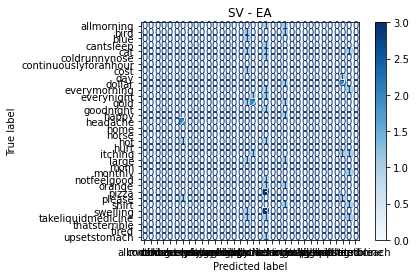

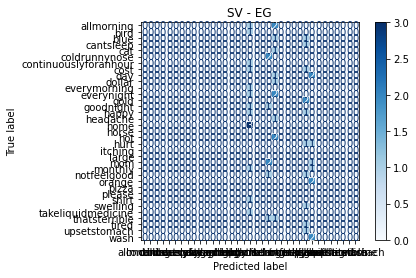

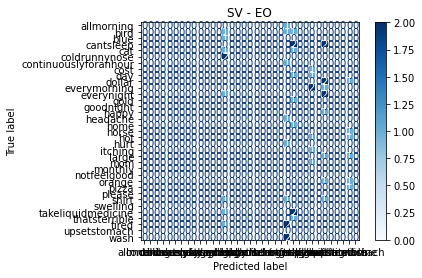

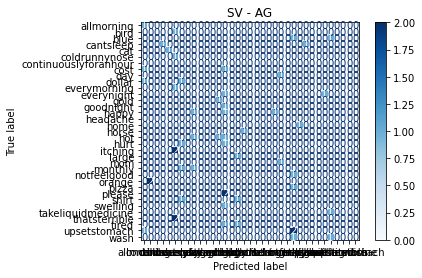

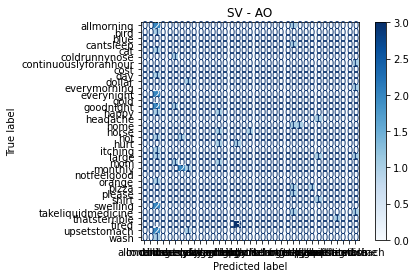

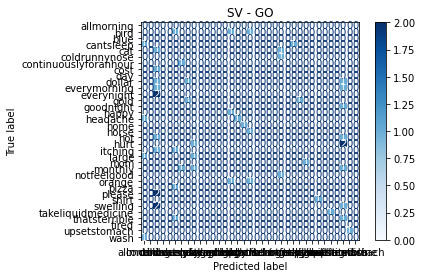

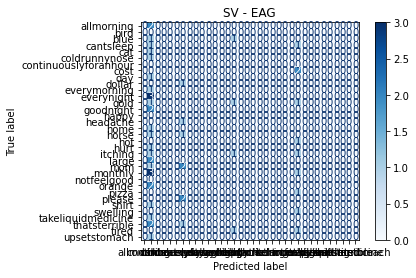

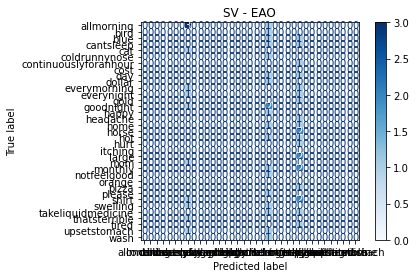

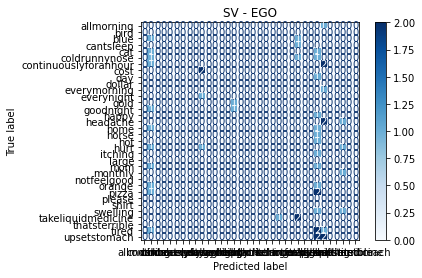

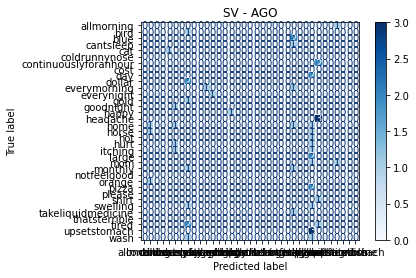

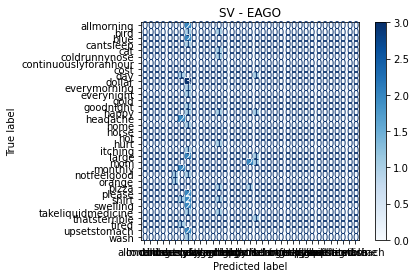

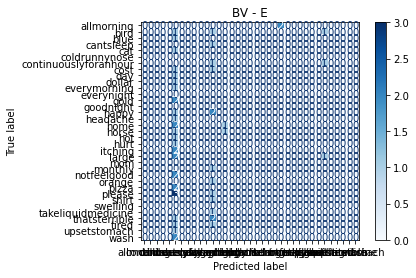

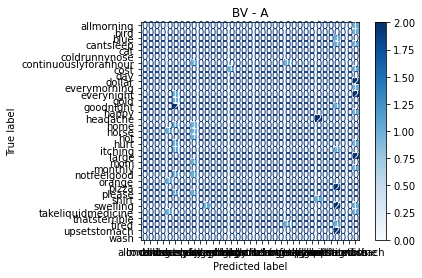

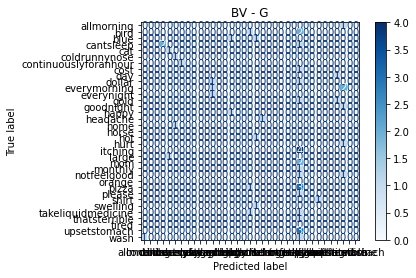

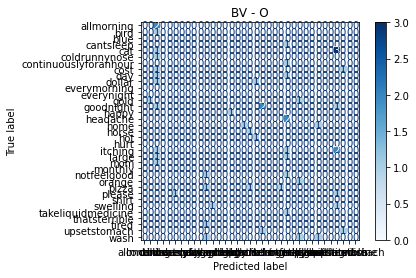

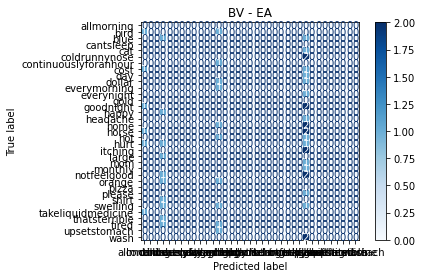

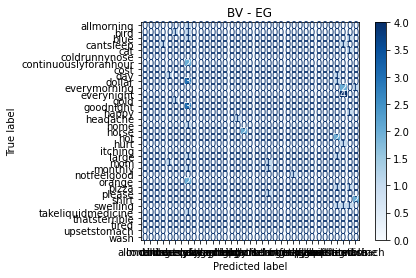

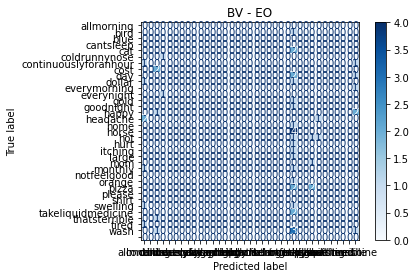

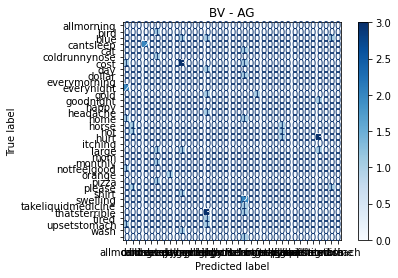

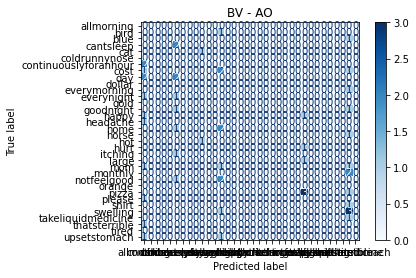

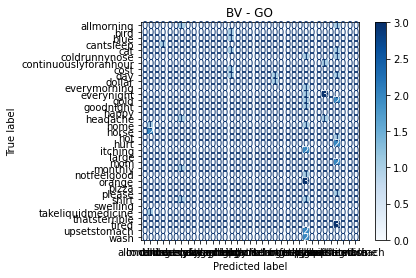

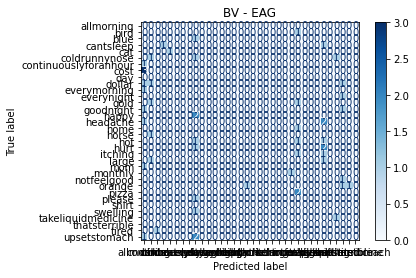

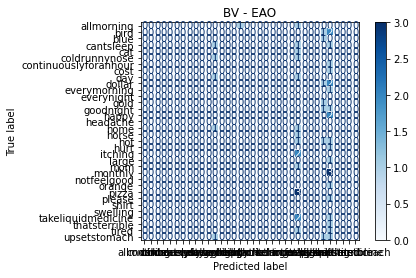

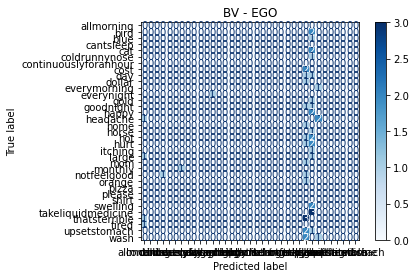

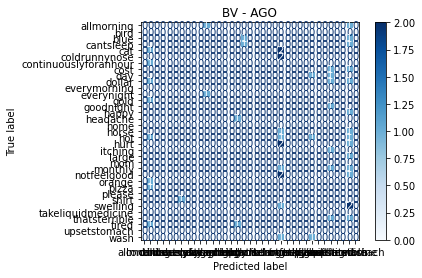

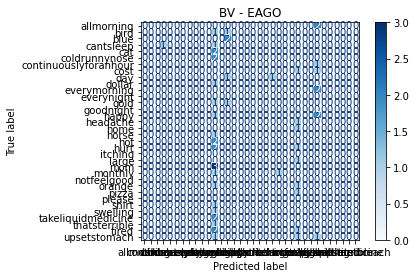

    EMG0L EMG0L     EMG0L      EMG0L  ...     EMG7R     EMG7R     EMG7R    EMG7R
16      0     0   1.78993  -0.651104  ...   2.57063   8.50468   7.01742  12.6794
57      0     0 -0.596644  0.0181533  ...  0.262494  -14.3366  -14.5285  2.17095
99      0     0   2.38658   -4.24912  ... -0.225021 -0.814659  -2.08136   0.5729
115     0     0   -10.143    6.87169  ...  -4.69882   2.50356   1.58959  3.30485
161     0     0   1.19329 -0.0363065  ...  -4.95312  -6.50054  -2.85794 -1.15772
..    ...   ...       ...        ...  ...       ...       ...       ...      ...
158     0     0  -1.19329    1.82624  ...  -3.07933  -2.67118  -1.34539  0.14277
124     0     0  -1.19329    1.22959  ...    14.481   4.73999  -13.8571 -9.15222
37      0     0  -1.19329    3.01953  ...  -1.89039   1.63292  0.763086  3.51461
1       0     0  -1.19329    1.22959  ...   1.71736  0.558537  -2.30323 -5.07678
2       0     0  -13.1262    12.9289  ...  0.367647  0.502338   1.16006  4.93608

[122 rows x 800 columns]
91

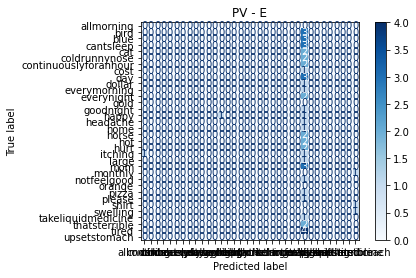

           AXL        AXL        AXL  ...       AZR       AZR       AZR
81  -0.0966797 -0.0874023  -0.108398  ...   1.02051   0.99707  0.985352
65   0.0791016  0.0927734  0.0854492  ...  0.963379   0.95752   0.94043
167  -0.419434  -0.401367    -0.4375  ...  0.876953  0.864746  0.930664
27   -0.524414  -0.525879  -0.513672  ...  0.759277  0.730957  0.731934
136  -0.654785  -0.656738  -0.665039  ...  0.948242   1.01172  0.995117
..         ...        ...        ...  ...       ...       ...       ...
45   0.0351562  0.0224609   0.160156  ...  0.874023   0.85791  0.899414
22  -0.0532227 -0.0610352 -0.0600586  ...   1.27344  0.963867  0.947754
25   -0.199707  -0.199707  -0.206543  ...  0.846191   1.05078  0.984863
71   -0.417969   -0.52002  -0.522949  ...  0.834473  0.866699  0.837891
82  -0.0712891 -0.0585938 -0.0825195  ...  0.480957  0.535156  0.615723

[122 rows x 300 columns]
2928


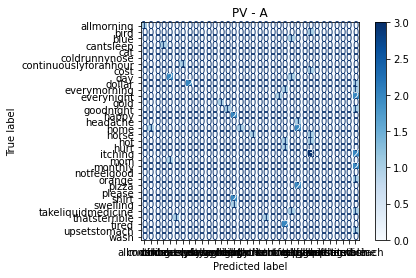

         GXL      GXL     GXL      GXL  ...      GZR     GZR      GZR     GZR
167   -2.375   -6.625   3.125   8.1875  ... -44.3125 -97.375 -101.875   -89.5
100   5.0625     9.75   36.25    8.625  ...   -6.375  -7.375    -7.25      -1
120  -9.1875   7.1875      -5    0.125  ...    6.125      24  -4.3125      -5
25   -0.9375  -0.9375  -3.375  -3.4375  ...  -1.6875  0.9375    1.875 -16.625
44    12.125  13.3125    6.25      2.5  ...      2.5    1.25   -0.375    0.75
..       ...      ...     ...      ...  ...      ...     ...      ...     ...
124    2.125   0.6875  2.5625   3.8125  ...  -5.3125  1.1875  -0.8125 -0.6875
141  90.8125   107.75   62.25  51.3125  ...  -33.875   -29.5 -26.0625  -23.25
111   -1.125   -0.125   2.375        3  ...    -1.75  -1.125  -0.4375  -0.125
103   5.3125     1.25   0.125      2.5  ...  -0.5625 -0.3125  -0.8125  -0.625
81    2.6875   2.4375   0.125      1.5  ...   1.8125  1.3125   1.6875     1.5

[122 rows x 300 columns]
4392


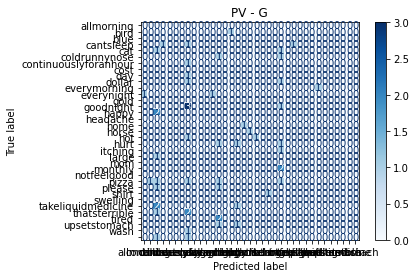

    ORL ORL ORL ORL ORL  ORL  ORL  ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR  OYR
89   63  64  64  64  64   64   64   64  ...  157  152  139  129  119  115  112  110
87   77  77  76  76  76   76   76   76  ...   78   67   60   58   58   58   59   59
80   85  85  85  85  85   85   85   85  ...  133  131  130  128  126  125  124  124
128  61  61  61  61  61   61   61   61  ...  177  177  177  177  176  176  176  175
121  78  78  78  78  79   79   78   78  ...  104  105  106  106  102   97   87   80
..   ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2    90  90  89  87  85   87   91   93  ...   23   23   22   22   22   22   22   22
167  74  74  73  74  74   73   73   72  ...  119  118  118  118  116  113  109  106
50   97  97  96  97  98  102  103  103  ...   86   85   85   85   85   85   85   85
92   65  65  64  64  64   64   64   64  ...  154  154  154  154  155  155  156  156
39   65  65  64  62  60   59   59   58  ...   20   20   20   20   20   20   

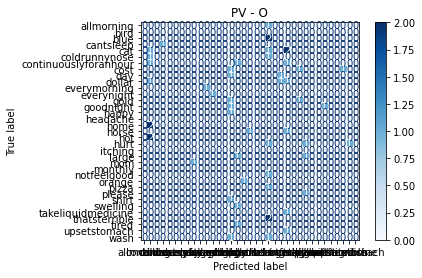

    EMG0L EMG0L     EMG0L      EMG0L  ...       AZR       AZR       AZR       AZR
117     0     0   2.98322     -21.57  ...  0.931152  0.968262   1.01465   1.13135
55      0     0   2.38658   -4.24912  ...  0.980469  0.955078   0.98291   1.03174
150     0     0 -0.596644  0.0181533  ...  0.705078  0.679199  0.692871  0.699219
59      0     0 -0.596644  -0.578491  ...  0.676758  0.649902  0.645508  0.649902
147     0     0         0   -2.38658  ...  0.799805  0.984863  0.815918  0.854004
..    ...   ...       ...        ...  ...       ...       ...       ...       ...
146     0     0 -0.596644   -1.77178  ...  0.951172   0.95752  0.962402   0.96582
3       0     0  -1.19329    1.22959  ...  0.897949  0.913086  0.965332   0.87207
34      0     0   7.75637   -6.79908  ...  0.624023  0.602051  0.650879  0.672363
168     0     0         0    3.57986  ...  0.917969  0.873535   0.87793  0.815918
165     0     0 -0.596644    2.40473  ...   1.16162    1.1001  0.887695  0.987305

[122 rows x 110

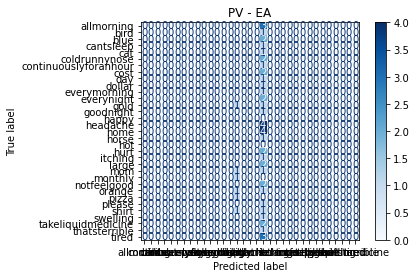

    EMG0L EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR      GZR
132     0     0         0         0  ... -117.125 -120.312 -78.3125      -64
142     0     0  -1.78993  -1.13883  ...  -62.125 -86.1875   -99.25  -107.75
82      0     0  -1.19329  0.632951  ... -117.125 -145.125  -155.75 -167.125
68      0     0   7.15973   -9.1675  ...      0.5   0.1875   -0.125    0.375
14      0     0  0.596644 -0.614797  ... -83.9375 -82.6875    -73.5 -50.8125
..    ...   ...       ...       ...  ...      ...      ...      ...      ...
33      0     0   2.38658 -0.072613  ...  -157.75 -133.062  -112.75 -65.1875
127     0     0 -0.596644  0.614797  ...  -1.9375       -1   -3.625  -20.625
99      0     0   2.38658  -4.24912  ...   0.4375  -5.1875   7.8125  -1.8125
135     0     0  -1.19329   1.22959  ...  16.6875     3.25        7     7.25
52      0     0         0  -2.38658  ...  -8.6875  -5.1875  -1.5625  -0.9375

[122 rows x 1100 columns]
6588


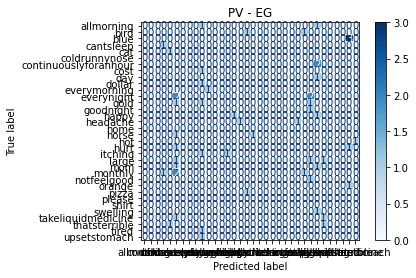

    EMG0L EMG0L     EMG0L     EMG0L       EMG0L  ...  OYR  OYR  OYR  OYR  OYR
135     0     0  -1.19329   1.22959 -0.00925186  ...  161  161  161  162  162
89      0     0  -1.19329   2.42288    -1.23885  ...  129  119  115  112  110
168     0     0         0   3.57986     -2.4955  ...  123  124  124  123  121
166     0     0  -4.17651   2.51365     2.11033  ...  109  106  104  102  101
26      0     0 -0.596644  -1.17514     3.33138  ...   71   71   70   70   70
..    ...   ...       ...       ...         ...  ...  ...  ...  ...  ...  ...
97      0     0  -1.19329  0.632951     3.58877  ...   90   90   90   89   89
79      0     0  -5.96644   6.14797     1.74367  ...   74   73   73   73   73
56      0     0   7.75637   6.92374    -20.9779  ...   85   85   85   85   85
54      0     0  -4.17651   4.90023    -2.13879  ...   81   83   84   85   86
69      0     0  -1.78993  -1.13883     4.55172  ...   81   81   81   81   81

[122 rows x 1100 columns]
7198


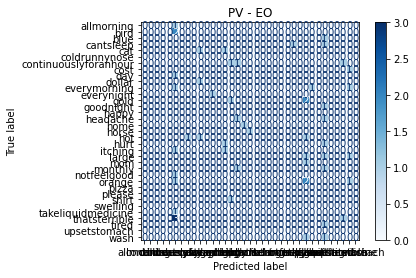

           AXL        AXL        AXL  ...     GZR     GZR      GZR
62   -0.427734  -0.412598  -0.442871  ... -1.6875    -8.5     3.25
127  -0.101562  -0.107422  -0.113281  ...      -1  -3.625  -20.625
41  -0.0166016 -0.0839844  0.0419922  ...   1.625   -12.5 -58.9375
72    0.744629   0.700195    0.32373  ... -0.3125   3.875   2.3125
153  -0.506348  -0.523438  -0.516602  ...  7.0625  11.625 -24.6875
..         ...        ...        ...  ...     ...     ...      ...
71   -0.417969   -0.52002  -0.522949  ...  -3.375 -3.0625   -1.625
164   0.474121    0.55127   0.610352  ...  0.3125  -0.125  -0.3125
24   -0.115234  -0.117188 -0.0742188  ...  1.3125  1.6875  -4.4375
76    0.582031   0.706055   0.876465  ...   0.875  0.4375    -0.75
149   -1.06885   -1.03076  -0.614258  ...  1.5625 -0.1875   -0.125

[122 rows x 600 columns]
4392


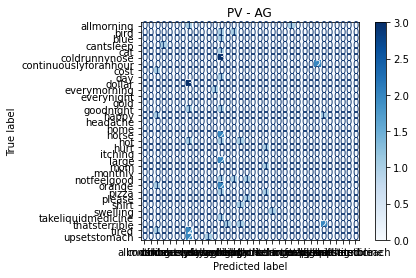

           AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
48    0.168457    0.14502   0.133301   0.134277  ...  164  162  161  160
137 -0.0756836 -0.0786133 -0.0649414 -0.0717773  ...   78   78   78   78
56    0.369141   0.794922   0.482422   0.237305  ...   85   85   85   85
159  -0.472168  -0.473145  -0.480957  -0.474609  ...   23   23   23   23
28   -0.537109  -0.533203  -0.523438  -0.527344  ...   16   16   16   16
..         ...        ...        ...        ...  ...  ...  ...  ...  ...
166  -0.379883  -0.394043  -0.361816  -0.374023  ...  106  104  102  101
93    0.724121   0.726562    0.74707   0.748047  ...  179  179  179  178
89   -0.635254  -0.633789  -0.626953  -0.605469  ...  119  115  112  110
2    -0.245605  -0.226074 -0.0908203   0.131348  ...   22   22   22   22
106   0.467285   0.347168   0.421875 -0.0634766  ...    5    7    8    9

[122 rows x 600 columns]
1586


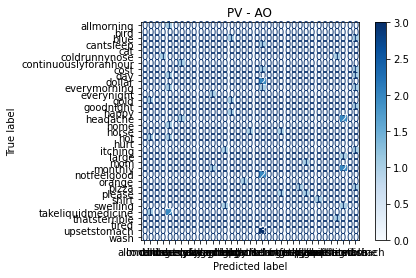

         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
18    -10.25    12.25 -56.1875   -4.625      -19  ...    4    4    3    3    3
114    -7.75       -6  12.6875  -1.4375  -2.5625  ...  176  176  176  176  176
96   225.438   173.75  184.875  145.562  97.5625  ...   89   89   89   89   89
164 -69.0625  -132.25     -144 -53.8125   42.875  ...   30   30   30   30   30
106    47.25  25.3125  -0.1875 -74.6875 -104.062  ...    0    5    7    8    9
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
17    0.3125   0.5625 -11.6875  -6.6875      -28  ...   97   97   97   95   94
146  21.3125    16.75 -12.1875  -21.875   -36.25  ...   78   78   78   78   78
100   5.0625     9.75    36.25    8.625  16.0625  ...   67   67   67   67   67
69    -15.75  -35.875    31.75  42.3125     41.5  ...   81   81   81   81   81
81    2.6875   2.4375    0.125      1.5   5.3125  ...   14   14   14   14   14

[122 rows x 600 columns]
4880


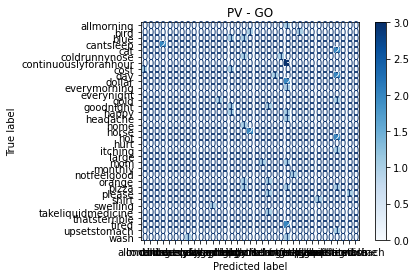

    EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
129     0     0 -0.596644  0.0181533  ...  -28.875  14.6875   -7.125   0.1875
28      0     0  -4.17651    5.49687  ...    -2.75   -4.625       -4    -3.25
17      0     0 -0.596644  0.0181533  ...    -30.5 -112.438     -149  -130.75
22      0     0  -1.78993   0.651104  ...  -5.6875   13.875     -8.5    -12.5
76      0     0   3.57986     -6.672  ...   4.1875    0.875   0.4375    -0.75
..    ...   ...       ...        ...  ...      ...      ...      ...      ...
159     0     0 -0.596644  0.0181533  ...        0   -0.875    -0.75    -0.75
125     0     0         0  -0.596644  ... -21.1875 -20.6875      -23 -11.8125
165     0     0 -0.596644    2.40473  ... -114.812 -79.5625  -48.875   -9.375
1       0     0  -1.19329    1.22959  ... -62.9375 -97.6875 -146.062 -184.562
81      0     0   2.38658   -5.44241  ...   1.8125   1.3125   1.6875      1.5

[122 rows x 1400 columns]
6466


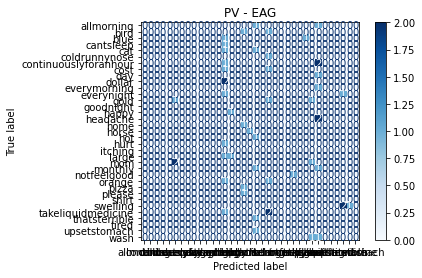

    EMG0L EMG0L     EMG0L     EMG0L       EMG0L  ...  OYR  OYR  OYR  OYR  OYR
135     0     0  -1.19329   1.22959 -0.00925186  ...  161  161  161  162  162
143     0     0  0.596644  -3.59802     2.18365  ...  177  174  170  165  162
127     0     0 -0.596644  0.614797   -0.302948  ...  176  175  175  175  174
77      0     0  -4.17651   1.91701     13.4647  ...   74   74   74   74   74
67      0     0  0.596644  -1.21144    0.917745  ...   38   39   39   39   39
..    ...   ...       ...       ...         ...  ...  ...  ...  ...  ...  ...
66      0     0  0.596644  -3.59802     5.16687  ...   82   82   82   82   82
3       0     0  -1.19329   1.22959    0.587392  ...   23   23   23   23   23
160     0     0   9.54631  -11.6267    -1.66146  ...  108  107  105  103  102
35      0     0   2.98322  -1.28405    -4.50616  ...    5    5    5    5    5
72      0     0   5.96644  0.415112    -12.0863  ...   15   15   15   15   15

[122 rows x 1400 columns]
6954


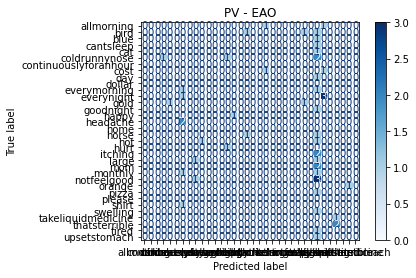

    EMG0L EMG0L     EMG0L     EMG0L       EMG0L  ...  OYR  OYR  OYR  OYR  OYR
115     0     0   -10.143   6.87169    -4.44455  ...   82   82   82   82   82
128     0     0  -1.19329   1.22959 -0.00925186  ...  177  176  176  176  175
39      0     0  -1.19329   2.42288    -2.43213  ...   20   20   20   20   20
54      0     0  -4.17651   4.90023    -2.13879  ...   81   83   84   85   86
40      0     0  0.596644  -2.40473      1.5507  ...   13   13   12   12   11
..    ...   ...       ...       ...         ...  ...  ...  ...  ...  ...  ...
118     0     0  0.596644  -3.59802     5.76351  ...  105  102  100   99  100
31      0     0  -4.17651   4.90023    0.844431  ...  108  107  106  104  101
125     0     0         0 -0.596644    -1.17514  ...  122  121  119  118  117
20      0     0 -0.596644  0.614797   -0.899592  ...   88   88   88   88   88
73      0     0  -2.38658   3.65248     6.50828  ...   16   16   16   16   17

[122 rows x 1400 columns]
6466


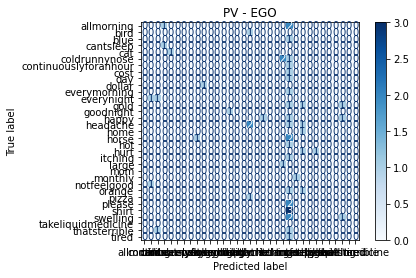

           AXL       AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
144  -0.577148 -0.625488   -0.65332  -0.513672  ...   86   86   86   86
147  -0.525879 -0.528809  -0.520508  -0.529297  ...   73   73   72   72
98   -0.121582 -0.194336  -0.349121  -0.260742  ...   77   77   77   77
150  -0.224609 -0.225586  -0.276367  -0.162109  ...  106  107  107  107
115   0.408691  0.420898   0.444336   0.350098  ...   82   82   82   82
..         ...       ...        ...        ...  ...  ...  ...  ...  ...
6    -0.493652 -0.481934  -0.524902  -0.533691  ...   64   62   60   60
92  -0.0673828   -0.0625 -0.0571289 -0.0507812  ...  155  155  156  156
89   -0.635254 -0.633789  -0.626953  -0.605469  ...  119  115  112  110
129  -0.140137 -0.142578  -0.144531  -0.141602  ...   11   11   11   11
158  -0.505371 -0.476562  -0.464844  -0.499512  ...   98   98   98   98

[122 rows x 900 columns]
4758


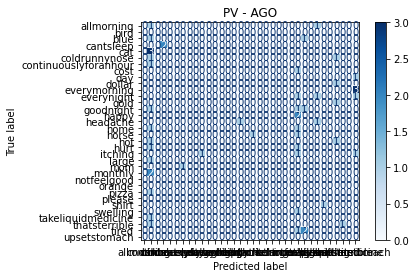

    EMG0L   EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
17      0       0 -0.596644  0.0181533 -0.881439  ...   97   97   97   95   94
7       0       0  -14.9161    32.6726  -11.0834  ...   92   92   92   91   91
19      0       0   13.1262   -5.76917  -18.0335  ...    3    2    1    1    1
151     0       0  -2.38658    3.65248  -2.44139  ...   88   88   88   88   88
114     0       0  -1.19329   -1.15698   2.44994  ...  176  176  176  176  176
..    ...     ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
1       0       0  -1.19329    1.22959 -0.605896  ...  133  131  129  125  119
72      0       0   5.96644   0.415112  -12.0863  ...   15   15   15   15   15
65      0       0    18.496   -30.9916  -1.58179  ...   45   45   45   45   45
14      0       0  0.596644  -0.614797  -0.89034  ...   69   71   73   75   76
15      0 -5.3698 -0.433265   -3.14164   11.8039  ...   95   95   95   95   95

[122 rows x 1700 columns]
6466


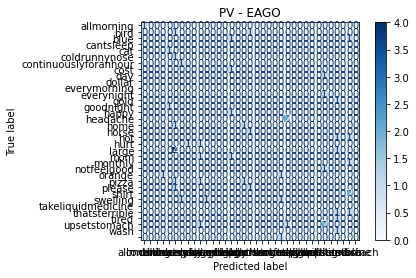

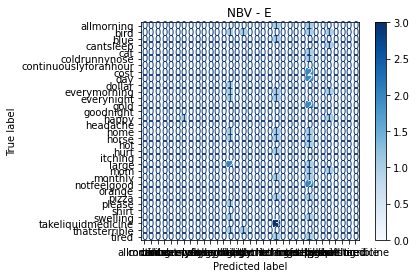

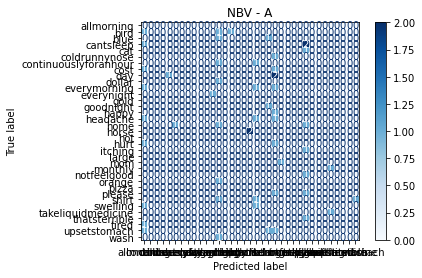

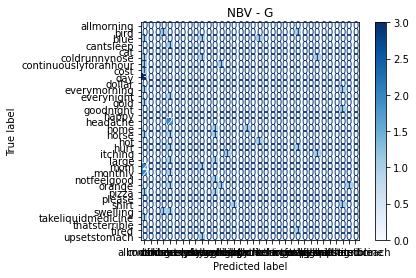

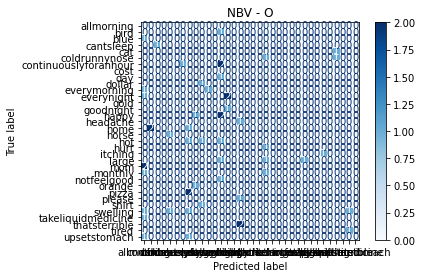

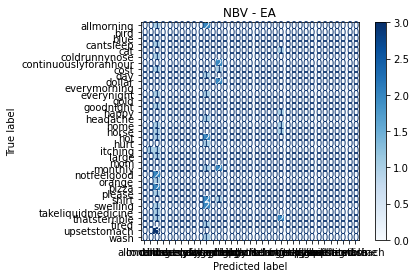

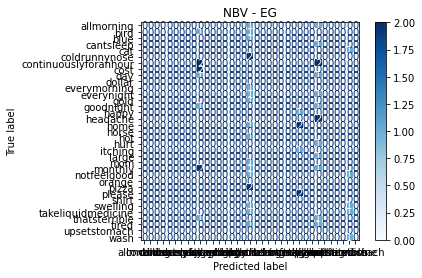

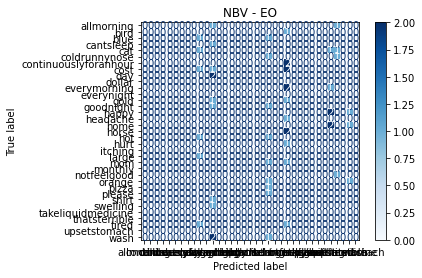

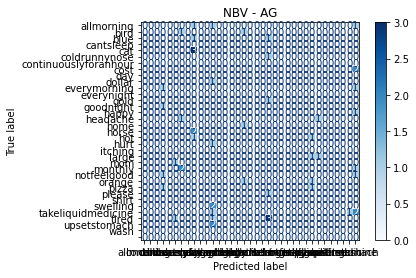

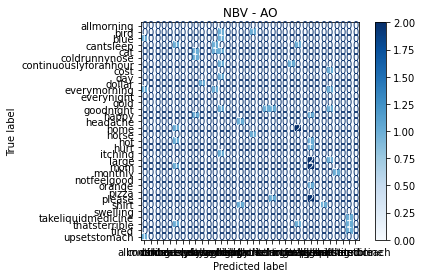

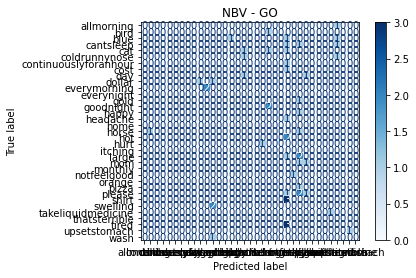

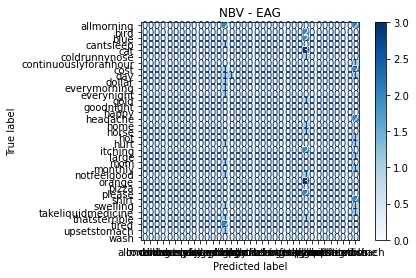

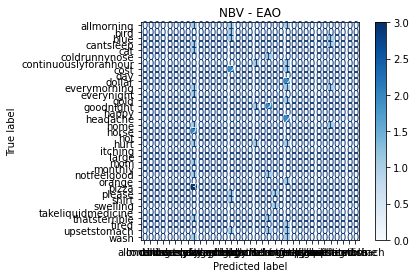

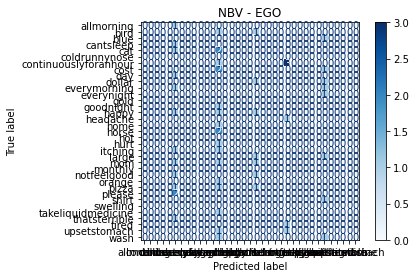

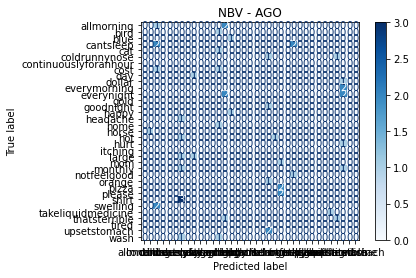

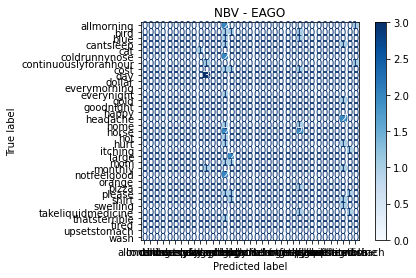

        EMG0L       EMG0L      EMG0L  ...        EMG7R       EMG7R       EMG7R
12   0.247956 -0.00754421  -0.137348  ...   0.00509628  -0.0283142   0.0226595
131  0.397763  -0.0121022  -0.216186  ...   -0.0167753   0.0254517  0.00205061
27   0.179871 -0.00547267 -0.0852392  ...     -0.04995  -0.0552517  -0.0537149
7    0.286389 -0.00871356  -0.215981  ...      0.02443  -0.0212911   -0.067423
44   0.302051 -0.00919009  -0.154145  ...  0.000255046   0.0104432   -0.045265
..        ...         ...        ...  ...          ...         ...         ...
5    0.393662  -0.0119774  -0.208832  ...    0.0232684   0.0623429 -0.00285118
25   0.279842 -0.00851436  -0.154186  ...   -0.0217645  0.00763895   0.0121637
97   0.361945  -0.0110124  -0.194834  ...  3.30506e-05   -0.012336   -0.006461
21   0.335228  -0.0101995   -0.17829  ...    0.0204269   0.0192231   0.0151245
83   0.284762 -0.00866405  -0.162397  ...   -0.0981804    0.139274  0.00888897

[122 rows x 800 columns]
10492


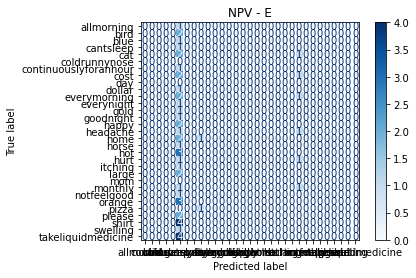

           AXL        AXL       AXL  ...       AZR       AZR       AZR
24    0.425594   0.425038  0.437266  ...  0.642073  0.639433  0.645964
26    0.171892   0.171892  0.164054  ...  0.850541  0.858108  0.853514
16    0.127582   0.128958   0.11106  ...  0.745295  0.622074  0.659247
22    0.259471    0.25511  0.255655  ...         1    0.8272  0.818205
81    0.260012   0.265957  0.252502  ...  0.975906  0.960886  0.953377
..         ...        ...       ...  ...       ...       ...       ...
164   0.661352    0.69585  0.722269  ...  0.795413  0.794321  0.791483
146   0.294488   0.282658   0.29625  ...  0.899069  0.901586  0.903348
94    0.813243   0.814303  0.806886  ...  0.919733  0.962914  0.975625
48    0.577819   0.567543  0.562405  ...  0.935987  0.920573  0.959965
117  0.0922731  0.0747686  0.105526  ...   0.84371  0.867467  0.927232

[122 rows x 300 columns]
2562


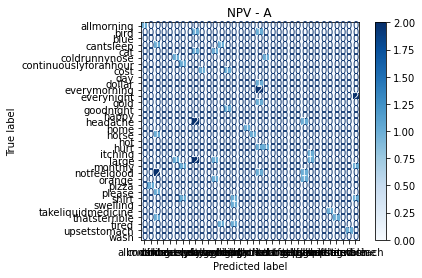

          GXL       GXL       GXL  ...       GZR       GZR       GZR
7    0.404153  0.398557  0.405056  ...  0.401084  0.389713  0.365344
73    0.45959  0.260025  0.459124  ...  0.336494  0.337582  0.353746
55    0.48549  0.496195  0.523376  ...  0.522205  0.521536  0.520449
149  0.665922  0.612151  0.541899  ...  0.573883  0.569972  0.570112
87   0.547588  0.542332  0.551061  ...  0.451474  0.495589   0.50169
..        ...       ...       ...  ...       ...       ...       ...
104  0.431299  0.424824  0.437226  ...  0.425593  0.426032  0.425483
88   0.541536  0.541045   0.53531  ...  0.453219  0.496149   0.51958
130  0.431321  0.428509  0.414449  ...   0.29483  0.359723  0.248107
170  0.455685    0.4483  0.485916  ...  0.530058   0.52628  0.523703
110  0.362711  0.362393  0.380104  ...  0.351681  0.356348  0.357302

[122 rows x 300 columns]
4026


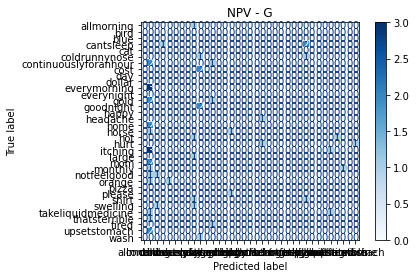

          ORL       ORL       ORL  ...        OYR        OYR        OYR
144  0.431373  0.421569  0.372549  ...   0.607843   0.607843   0.607843
149  0.469274   0.47486   0.47486  ...   0.324022   0.324022   0.324022
55   0.635294  0.635294  0.658824  ...   0.623529   0.623529   0.623529
141  0.503597  0.510791   0.57554  ...   0.654676   0.661871   0.661871
101   0.22449  0.244898  0.265306  ...  0.0408163  0.0204082  0.0204082
..        ...       ...       ...  ...        ...        ...        ...
84   0.486726  0.486726  0.486726  ...  0.0353982  0.0265487  0.0176991
96   0.639344  0.737705  0.819672  ...    0.47541    0.47541    0.47541
162      0.74      0.73      0.72  ...       0.71       0.71       0.71
169  0.468085  0.468085  0.468085  ...   0.113475  0.0780142  0.0567376
23   0.342697  0.342697  0.342697  ...    0.88764    0.88764   0.876404

[122 rows x 300 columns]
1586


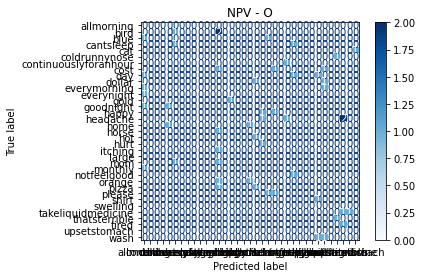

        EMG0L       EMG0L      EMG0L  ...       AZR       AZR       AZR
37   0.342337  -0.0104158  -0.185451  ...  0.851807  0.868637  0.899222
160  0.337922  -0.0102815  -0.134382  ...  0.775878  0.849953  0.892686
26   0.282197   -0.008586  -0.155559  ...  0.850541  0.858108  0.853514
81   0.403138  -0.0122657  -0.189208  ...  0.975906  0.960886  0.953377
122  0.312528 -0.00950885  -0.175526  ...  0.992671   0.88889  0.841794
..        ...         ...        ...  ...       ...       ...       ...
32   0.385709  -0.0117354  -0.195573  ...  0.776241  0.795562  0.824544
168  0.292693 -0.00890537  -0.152983  ...  0.935775   0.93839  0.901482
60   0.293378 -0.00892619  -0.166526  ...  0.848608  0.848608  0.847806
63   0.271844 -0.00827101  -0.145616  ...  0.880152  0.874029  0.876619
113  0.307743 -0.00936326 -0.0854831  ...  0.834148  0.816804  0.828728

[122 rows x 1100 columns]
8174


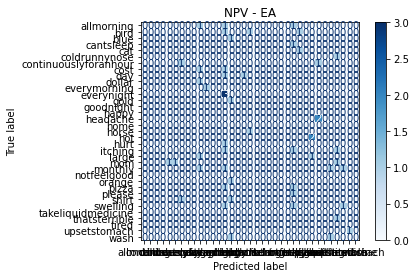

        EMG0L       EMG0L     EMG0L  ...         GZR        GZR        GZR
26   0.282197   -0.008586 -0.155559  ...    0.464001    0.47463   0.480831
104   0.35202  -0.0107104 -0.189958  ...    0.425593   0.426032   0.425483
139  0.323604 -0.00984583 -0.174195  ...    0.403634   0.418222   0.412659
25   0.279842 -0.00851436 -0.154186  ...    0.447932   0.449709   0.414642
82   0.305102 -0.00928291 -0.173029  ...   0.0582396  0.0301125          0
..        ...         ...       ...  ...         ...        ...        ...
122  0.312528 -0.00950885 -0.175526  ...    0.427704   0.478438   0.472278
8    0.311293 -0.00947126 -0.169189  ...  0.00746422          0  0.0437503
153  0.258368 -0.00786101 -0.145696  ...    0.415142   0.425339   0.344183
110  0.338798  -0.0103081  -0.17708  ...    0.351681   0.356348   0.357302
72   0.283529 -0.00862655 -0.123538  ...    0.473731   0.485827   0.481314

[122 rows x 1100 columns]
9394


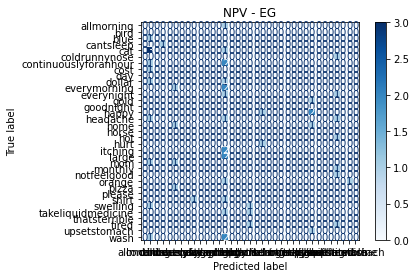

        EMG0L       EMG0L     EMG0L  ...        OYR        OYR         OYR
20   0.357986   -0.010892 -0.191371  ...   0.677686   0.677686    0.677686
90   0.275049 -0.00836852 -0.147992  ...   0.779661   0.774011    0.774011
50   0.350204  -0.0106552  -0.21763  ...   0.635514   0.635514    0.635514
7    0.286389 -0.00871356 -0.215981  ...   0.474227   0.463918    0.463918
146  0.355692  -0.0108221 -0.191647  ...   0.326087   0.326087    0.326087
..        ...         ...       ...  ...        ...        ...         ...
171  0.324103 -0.00986103 -0.125204  ...  0.0310078  0.0232558  0.00775194
158  0.268954 -0.00818307 -0.146757  ...   0.765306   0.765306    0.765306
4    0.219644 -0.00668279 -0.141028  ...   0.445652   0.445652    0.445652
38    0.31433 -0.00956367 -0.170112  ...   0.756522   0.747826    0.747826
31   0.291837 -0.00887931 -0.175233  ...   0.901408   0.873239    0.830986

[122 rows x 1100 columns]
5246


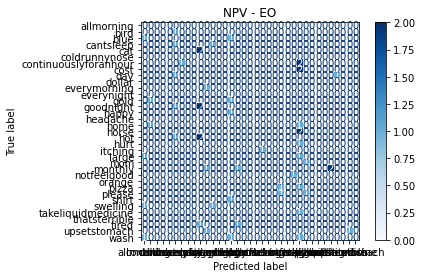

            AXL         AXL         AXL  ...       GZR        GZR        GZR
85     0.166885    0.169278    0.171889  ...  0.395285   0.405946   0.429114
0      0.320765    0.327835     0.34695  ...   0.52438   0.520794   0.520077
17    0.0238038   0.0252462   0.0302955  ...  0.113706  0.0272068  0.0703829
92     0.389432    0.392009    0.394844  ...  0.557817    0.60654   0.592681
101   0.0814494    0.107154   0.0774238  ...  0.350579   0.363551   0.383558
..          ...         ...         ...  ...       ...        ...        ...
159    0.167066    0.166666    0.163469  ...  0.556688   0.556912   0.556912
84   0.00781228  0.00833335  0.00234347  ...  0.336039    0.35777    0.39102
86     0.154735    0.154735    0.138643  ...  0.343622   0.380472   0.402148
79     0.268857    0.353115    0.371915  ...  0.179841   0.273946   0.347779
113    0.195664    0.199187    0.194039  ...  0.496999   0.505599   0.492456

[122 rows x 600 columns]
4270


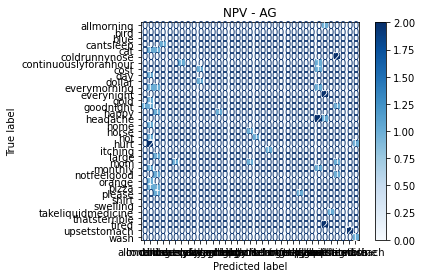

            AXL         AXL        AXL  ...        OYR        OYR        OYR
138    0.188451    0.185004    0.18759  ...   0.698413   0.587302   0.492063
129    0.432804    0.431912   0.431198  ...          0          0          0
163    0.195676    0.222302   0.334525  ...   0.023622   0.023622   0.023622
83   0.00996118  0.00945062          0  ...  0.0608696  0.0434783  0.0347826
151    0.355196    0.375934   0.406076  ...   0.684211   0.684211   0.684211
..          ...         ...        ...  ...        ...        ...        ...
118   0.0682632   0.0629142   0.038971  ...   0.746479   0.732394   0.746479
48     0.577819    0.567543   0.562405  ...   0.905028   0.899441   0.893855
57     0.284673    0.286315   0.434125  ...   0.101695   0.101695   0.101695
148   0.0906004   0.0953001  0.0890337  ...   0.260274   0.260274   0.260274
5      0.552921    0.554799   0.540952  ...          1          0          0

[122 rows x 600 columns]
2318


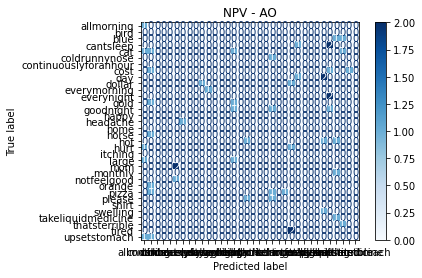

          GXL       GXL       GXL  ...        OYR        OYR        OYR
124  0.471199  0.468965  0.471879  ...   0.351562   0.351562   0.351562
65   0.407866  0.415443  0.260035  ...          0          0          0
28   0.483537  0.486188  0.495953  ...          0          0          0
106  0.618732  0.577223  0.528974  ...  0.0391061  0.0446927  0.0502793
120  0.391871  0.432516  0.402265  ...   0.534247   0.534247   0.534247
..        ...       ...       ...  ...        ...        ...        ...
136  0.395475  0.400748  0.419288  ...          1   0.977528   0.960674
156   0.50238  0.531535  0.612257  ...    0.82243   0.813084   0.813084
71   0.498043  0.194887  0.261692  ...  0.0512821  0.0512821  0.0512821
149  0.665922  0.612151  0.541899  ...   0.324022   0.324022   0.324022
98   0.473159  0.244382  0.432896  ...   0.391304   0.391304   0.391304

[122 rows x 600 columns]
2928


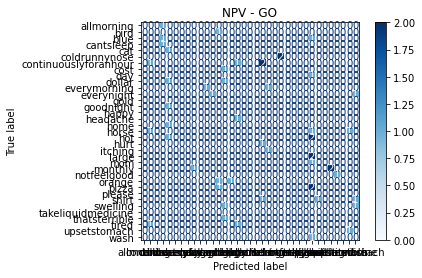

        EMG0L       EMG0L     EMG0L  ...       GZR       GZR       GZR
106  0.299492 -0.00911222 -0.184614  ...  0.610809  0.565397  0.546358
88   0.359986  -0.0109528 -0.191488  ...  0.453219  0.496149   0.51958
160  0.337922  -0.0102815 -0.134382  ...  0.286819  0.261533  0.352144
39   0.319331 -0.00971583 -0.172508  ...  0.473456  0.456991   0.45279
98   0.249058 -0.00757774  0.132567  ...  0.565231  0.544632  0.566792
..        ...         ...       ...  ...       ...       ...       ...
80   0.279766 -0.00851205 -0.149081  ...  0.440415  0.443303  0.452396
26   0.282197   -0.008586 -0.155559  ...  0.464001   0.47463  0.480831
120  0.342468  -0.0104198  -0.18435  ...  0.474248  0.403971  0.402265
20   0.357986   -0.010892 -0.191371  ...  0.479276  0.479717  0.479827
78   0.234849 -0.00714543 -0.116402  ...  0.309355  0.329361  0.371285

[122 rows x 1400 columns]
7930


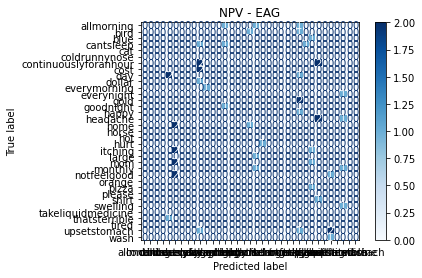

        EMG0L       EMG0L     EMG0L  ...        OYR        OYR        OYR
63   0.271844 -0.00827101 -0.145616  ...   0.829787   0.829787   0.822695
117  0.298322 -0.00907663 -0.141984  ...   0.736111   0.736111   0.736111
159  0.313156 -0.00952795 -0.166974  ...  0.0225564  0.0225564  0.0225564
120  0.342468  -0.0104198  -0.18435  ...   0.534247   0.534247   0.534247
37   0.342337  -0.0104158 -0.185451  ...   0.756522   0.747826   0.747826
..        ...         ...       ...  ...        ...        ...        ...
95   0.290956 -0.00885251 -0.159441  ...   0.731959   0.721649   0.721649
89   0.335193  -0.0101985   -0.1819  ...   0.671233   0.650685   0.636986
133  0.309053 -0.00940313 -0.170118  ...   0.324324   0.324324   0.324324
94    0.18571 -0.00565035 -0.104968  ...          0          0          1
60   0.293378 -0.00892619 -0.166526  ...  0.0502793  0.0502793  0.0502793

[122 rows x 1400 columns]
5246


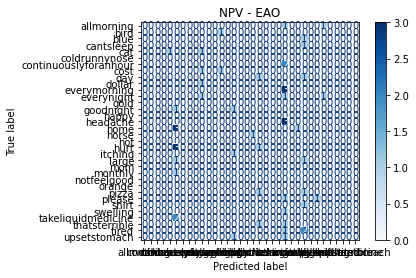

        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
58   0.258838 -0.00787531  -0.135288  ...   0.101695   0.101695   0.101695
164  0.213087 -0.00648331  -0.159319  ...          0          0          0
159  0.313156 -0.00952795  -0.166974  ...  0.0225564  0.0225564  0.0225564
114  0.248602 -0.00756386  -0.138224  ...   0.983146   0.983146   0.983146
65   0.254619 -0.00774693 -0.0152735  ...          0          0          0
..        ...         ...        ...  ...        ...        ...        ...
112   0.39263   -0.011946  -0.205217  ...   0.355263   0.342105   0.342105
48   0.369351  -0.0112377   -0.19305  ...   0.905028   0.899441   0.893855
141  0.330449  -0.0100541  -0.178836  ...   0.654676   0.661871   0.661871
143  0.299492 -0.00911222  -0.154196  ...   0.949721   0.921788   0.905028
111  0.246613 -0.00750335  -0.144808  ...   0.748031   0.748031   0.748031

[122 rows x 1400 columns]
5856


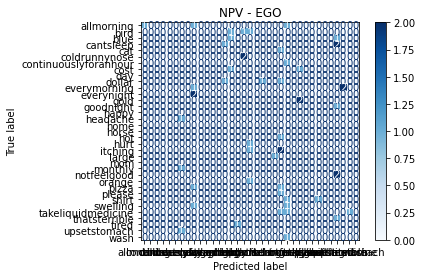

            AXL         AXL         AXL  ...        OYR        OYR        OYR
23     0.390044    0.388609    0.390523  ...    0.88764    0.88764   0.876404
115    0.520075    0.526812    0.539747  ...   0.586667   0.586667   0.586667
66     0.347293    0.356077    0.378345  ...   0.474227   0.474227   0.474227
156   0.0696419   0.0736985    0.100068  ...    0.82243   0.813084   0.813084
78     0.270972    0.269133    0.263847  ...   0.660194   0.650485   0.650485
..          ...         ...         ...  ...        ...        ...        ...
174    0.470573    0.473658    0.510678  ...          1   0.991525   0.991525
130  0.00359531  0.00667677  0.00539296  ...   0.932961   0.916201   0.910615
1      0.512693    0.549583    0.623561  ...      0.944      0.912      0.864
136   0.0880455   0.0872378   0.0838047  ...          1   0.977528   0.960674
60     0.682576    0.688391    0.688792  ...  0.0502793  0.0502793  0.0502793

[122 rows x 900 columns]
3538


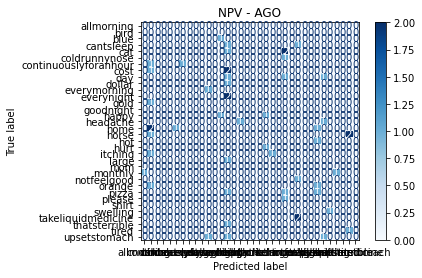

        EMG0L       EMG0L     EMG0L  ...        OYR        OYR        OYR
162  0.303213 -0.00922542  -0.15522  ...       0.71       0.71       0.71
67   0.287363  -0.0087432 -0.147762  ...  0.0952381  0.0952381  0.0952381
7    0.286389 -0.00871356 -0.215981  ...   0.474227   0.463918   0.463918
165  0.303057  -0.0092207 -0.161557  ...   0.480769   0.461538   0.442308
150  0.296236 -0.00901315 -0.159007  ...   0.929825   0.929825   0.929825
..        ...         ...       ...  ...        ...        ...        ...
39   0.319331 -0.00971583 -0.172508  ...          0          0          0
70   0.259716 -0.00790201 -0.125217  ...   0.814815   0.796296   0.787037
115  0.324981 -0.00988773  -0.21302  ...   0.586667   0.586667   0.586667
0    0.284884 -0.00866777 -0.191902  ...   0.522059   0.522059   0.522059
61   0.209729 -0.00638114   -0.1277  ...   0.056962   0.056962   0.056962

[122 rows x 1700 columns]
6100


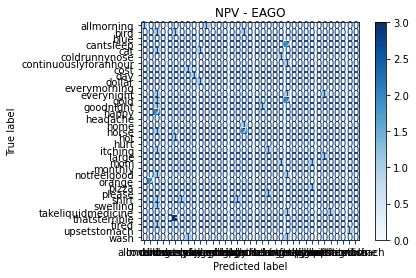

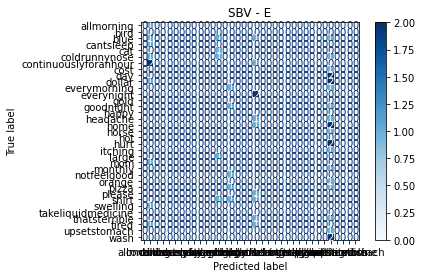

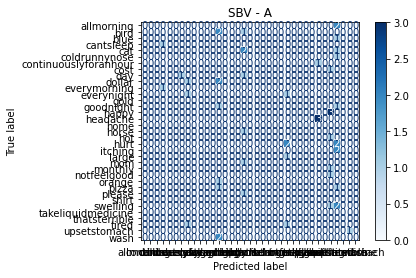

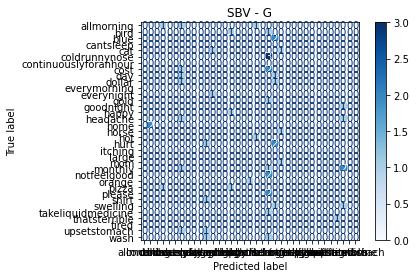

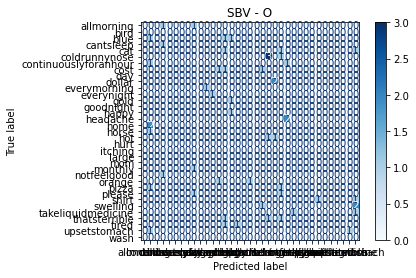

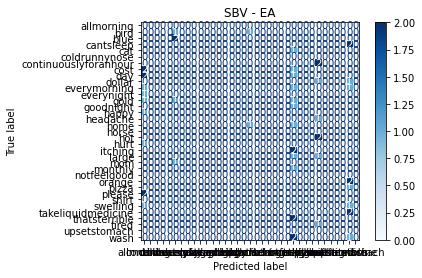

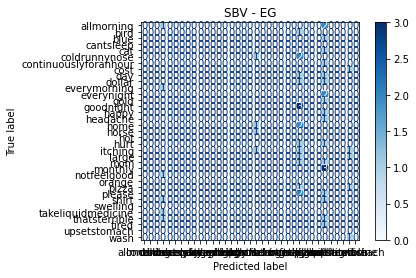

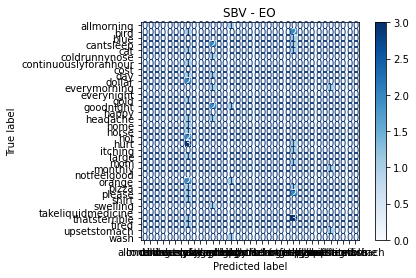

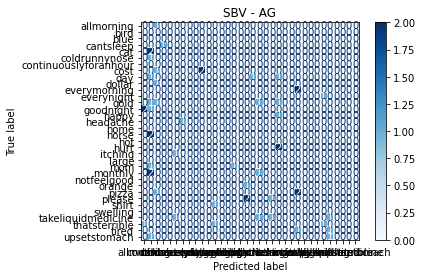

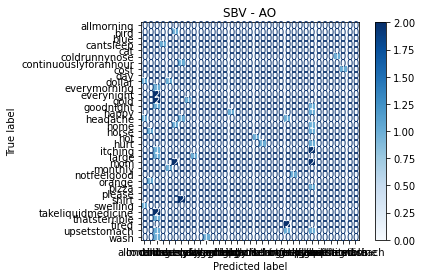

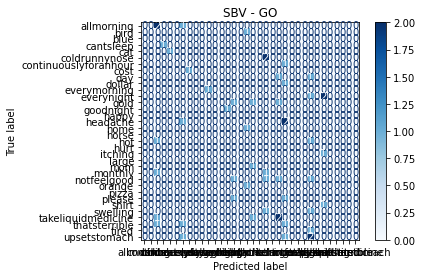

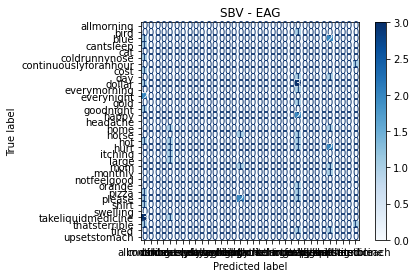

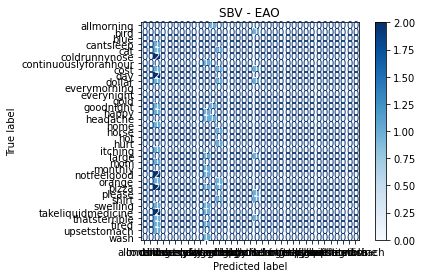

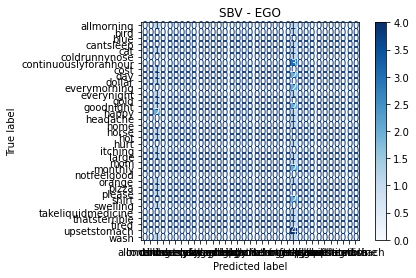

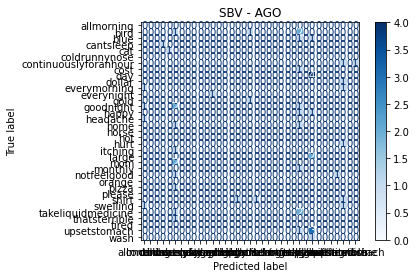

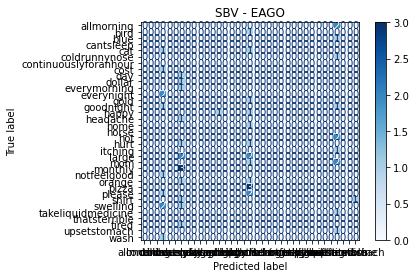

         EMG0L        EMG0L       EMG0L  ...      EMG7R      EMG7R      EMG7R
15   0.0600263    -0.328995  -0.0577719  ...   0.755868   0.901222    0.41342
129  0.0461973  -0.00140558  -0.0586538  ...    1.10873   0.623669  0.0284688
90    0.100768  -0.00306591   -0.121569  ...   0.418447  -0.904548  -0.567794
5    0.0360272  -0.00109615  -0.0569545  ...   0.288437    0.77281 -0.0353436
123   0.101887  -0.00309996   -0.131327  ...  -0.174934   0.124995   0.550733
..         ...          ...         ...  ...        ...        ...        ...
71   0.0417021  -0.00126881   -0.123046  ...  0.0391714   0.157117  0.0925222
132  0.0691267  -0.00210322  -0.0361306  ...   0.488088  -0.121466  -0.479395
87   0.0492071  -0.00149716  -0.0976857  ...  -0.513224 -0.0116194  -0.106992
70    0.015551 -0.000473147    0.117961  ...   0.667941    1.41555   -1.28976
67    0.060387  -0.00183731  0.00629757  ... -0.0137003  -0.165529  -0.049283

[122 rows x 800 columns]
10980


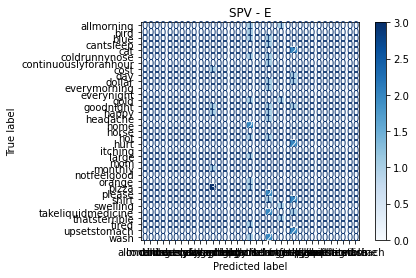

          AXL        AXL       AXL  ...       AZR       AZR       AZR
51   -1.29829   -1.13009 -0.610544  ...   1.05742   1.05929   1.41531
49   -1.22047   -1.19746 -0.751241  ...  0.835843   0.83201  0.845045
105  0.343857   0.359631  0.375407  ...   1.62661   1.19321    1.4041
100  -1.08316    -1.0545  -1.09705  ...   1.15758   1.23748   1.21316
159  -1.10315   -1.10486  -1.11851  ...   1.03798    1.0303   1.03201
..        ...        ...       ...  ...       ...       ...       ...
5   -0.058361 -0.0511606 -0.104254  ...   1.41474   1.42464   1.41024
125  -1.34395   -1.29619  -1.29116  ...   1.23884   1.37376   1.17683
130   -1.6535   -1.64268  -1.64719  ...    1.1451   1.44443   1.67795
143 -0.320481  -0.147476  0.121525  ...  0.411624  0.402131  0.536102
41  -0.731978  -0.873547 -0.608873  ...   0.20977  0.330822  0.367753

[122 rows x 300 columns]
3172


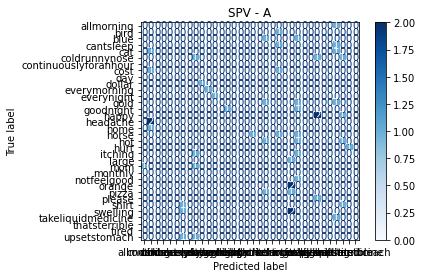

             GXL        GXL        GXL  ...        GZR        GZR        GZR
138 -0.000591897 -0.0142526  0.0205201  ...   -2.23847    -3.2953   -3.19098
128   -0.0437082 -0.0225962 -0.0801745  ...  -0.235636  -0.270183  -0.688585
74     0.0214681  0.0439087  0.0414153  ...   0.649804   0.789434   0.886677
153   -0.0453915 -0.0234121  0.0107781  ...   0.187835   0.276973  -0.432474
46      -2.04093    -1.7719    -1.2002  ... -0.0568109 -0.0618553 -0.0484036
..           ...        ...        ...  ...        ...        ...        ...
110   -0.0291743 -0.0320308   0.126981  ...    -0.1282 -0.0863044 -0.0777349
58     -0.401903  -0.683644  -0.530095  ... -0.0370489 -0.0102836 -0.0257793
45      0.528774    1.24617   0.411443  ...  0.0896189  0.0516258 -0.0567663
105    -0.188409 -0.0425515  0.0303771  ...    1.89795    1.86487    1.13558
119    -0.200116  -0.180479  -0.144226  ...  -0.112505   -0.14045  -0.102686

[122 rows x 300 columns]
4636


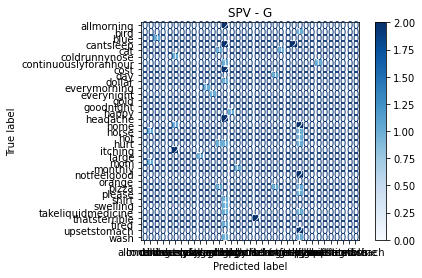

           ORL        ORL       ORL  ...        OYR        OYR        OYR
13   -0.600856  -0.600856 -0.600856  ...   -1.03014  -0.987212   -1.07307
31   -0.287646  -0.339042 -0.133458  ...    1.51121    1.40842    1.25423
76   -0.265197  -0.225792 -0.146981  ...  -0.186387  -0.186387  -0.186387
117  -0.288212   -0.35137 -0.477686  ...   0.974951   0.974951   0.974951
40   0.0788062  0.0788062  0.170088  ...   -1.58708   -1.58708    -1.6099
..         ...        ...       ...  ...        ...        ...        ...
168   -1.55878   -1.55878  -1.55878  ...    1.66719    1.60136    1.46968
21    0.227567   0.227567  0.227567  ... -0.0448906 -0.0448906 -0.0448906
84   -0.180478  -0.180478 -0.180478  ...   -1.61418   -1.64229    -1.6704
146  -0.278431  -0.209341 -0.209341  ...   -0.41661   -0.41661   -0.41661
118  -0.340064  -0.340064 -0.340064  ...   0.941585   0.877503   0.941585

[122 rows x 300 columns]
1830


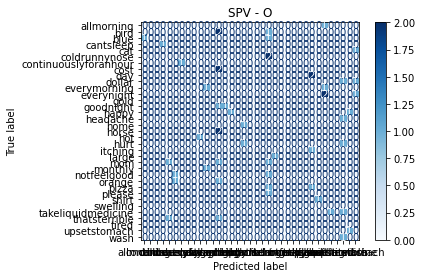

          EMG0L        EMG0L       EMG0L  ...       AZR       AZR       AZR
78     0.050585  -0.00153908   0.0450589  ...   1.39658   1.44853   1.29778
135   0.0740573  -0.00225324   -0.141654  ...  0.812299  0.662185  0.781062
85    0.0499623  -0.00152013  -0.0997909  ...   2.02992   1.94842   1.94427
18    0.0698505  -0.00212524     2.88472  ...   0.99658   1.04451   1.04799
83   0.00798789 -0.000243036   -0.176886  ...   1.26524   1.37588   1.56886
..          ...          ...         ...  ...       ...       ...       ...
136     0.02373 -0.000721999   -0.012403  ...   1.30176   1.41102   1.38245
165    0.105231  -0.00320172  -0.0991465  ...    1.4967   1.06978   1.26999
35    0.0105592  -0.00032127    0.183884  ...   1.24416   1.25417   1.26509
58  -0.00879783  0.000267679  0.00459838  ...  0.757026   0.78979  0.806592
141   0.0748119   -0.0022762   -0.148918  ...   1.07103   1.78219  0.627076

[122 rows x 1100 columns]
10980


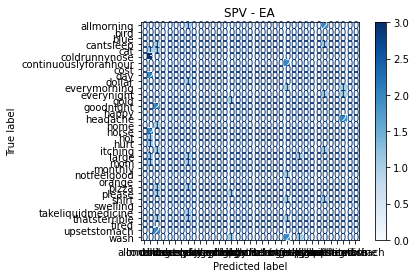

         EMG0L       EMG0L       EMG0L  ...        GZR        GZR         GZR
60   0.0703809 -0.00214138   -0.211104  ...  0.0345926  -0.100347  -0.0831934
26   0.0854769 -0.00260069    -0.17178  ...  -0.216835  -0.121722  -0.0662392
71   0.0417021 -0.00126881   -0.123046  ... -0.0188583 -0.0125624   0.0163987
106  0.0743698 -0.00226275    -0.30849  ...   0.557906   0.264829    0.141951
148  0.0377321 -0.00114802  -0.0569878  ...  -0.168752  0.0578572    -0.07968
..         ...         ...         ...  ...        ...        ...         ...
101  0.0529121 -0.00160988   -0.209328  ...  -0.373406  -0.270838    -0.11266
32   0.0284862 -0.00086671   0.0583875  ...    1.57848  -0.404535    0.605849
54    0.100398 -0.00305467   -0.347454  ...   -0.19344  -0.360867   -0.384121
21   0.0331211 -0.00100773  -0.0594369  ...  -0.186845 -0.0397087   0.0725506
51   0.0967614 -0.00294402  0.00727984  ...  -0.187205 -0.0587555  0.00546946

[122 rows x 1100 columns]
10980


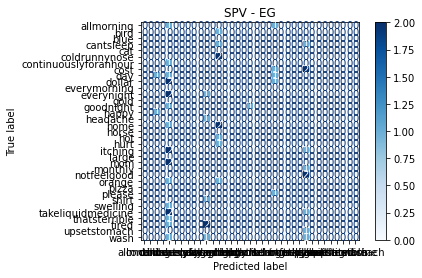

          EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
9   -0.00829146  0.000252273 -0.0877936  ...   -1.5855  -1.61948  -1.61948
29    0.0585211  -0.00178054  -0.212283  ...  -1.52449  -1.52449  -1.52449
146   0.0719433  -0.00218892  -0.112544  ...  -0.41661  -0.41661  -0.41661
120   0.0295758 -0.000899862 -0.0810005  ...   -0.3357   -0.3357   -0.3357
31    0.0259872 -0.000790677  -0.369398  ...   1.51121   1.40842   1.25423
..          ...          ...        ...  ...       ...       ...       ...
36     0.117021  -0.00356044  -0.152945  ...  -1.01713  -1.01713  -1.01713
124   0.0694243  -0.00211228  -0.141276  ... -0.705281 -0.705281 -0.705281
101   0.0529121  -0.00160988  -0.209328  ...  -1.49408  -1.56028  -1.56028
13   0.00174158 -5.29887e-05 -0.0879894  ...  -1.03014 -0.987212  -1.07307
35    0.0105592  -0.00032127   0.183884  ...  -2.13735  -2.13735  -2.13735

[122 rows x 1100 columns]
10614


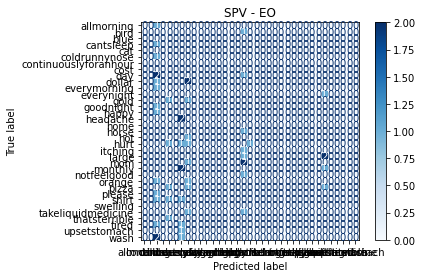

          AXL       AXL        AXL  ...         GZR          GZR         GZR
52  -0.556673 -0.261439   -0.45577  ...   -0.110845    -0.058134  -0.0490458
124  -1.23679  -1.23843   -1.32618  ...   0.0226761  -0.00311659 -0.00150455
137 -0.750992 -0.756719  -0.729992  ... -0.00579921  -0.00217857 -0.00217857
139  -1.23822  -1.23661   -1.18288  ...  -0.0646054     0.066284   0.0163686
75  -0.574139 -0.533186  0.0519795  ...    0.100903    -0.206047    0.071854
..        ...       ...        ...  ...         ...          ...         ...
122  -0.72252 -0.719728  -0.732759  ...   -0.944117    -0.458413   -0.517391
126   0.43937  0.432549   0.438394  ...   -0.151997    -0.063733   0.0130179
116  -1.11737  -1.19429   -1.27121  ...   -0.442319    -0.232189   0.0333589
2    -1.57923  -1.53296   -1.21255  ...   0.0550929 -0.000272008  0.00441994
160  -1.28135  -1.32938   -1.44067  ...     -1.5387     -1.66729     -1.2065

[122 rows x 600 columns]
5246


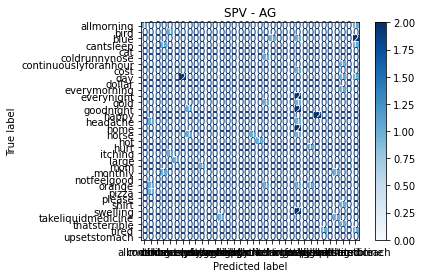

          AXL       AXL       AXL  ...        OYR        OYR          OYR
11   -0.76049 -0.775087 -0.739081  ...  -0.860714  -0.860714    -0.860714
82  -0.413515 -0.390781 -0.433625  ...   -1.99352     2.3007       2.0539
1   -0.420047 -0.254056   0.07882  ...    1.50067    1.35798      1.14396
151 -0.705226 -0.624393 -0.506904  ...   0.652709   0.652709     0.652709
22  -0.803934 -0.820149 -0.818122  ...  0.0400347  0.0400347 -0.000133895
..        ...       ...       ...  ...        ...        ...          ...
167  -1.00832 -0.977172  -1.03947  ...   0.932512   0.672215     0.476993
34   -1.99518  -2.04526   -1.9328  ...  -0.810307  -0.855001    -0.899696
114  -1.20819  -1.23475  -1.31273  ...    2.10362    2.10362      2.10362
145  -1.81916  -1.23523 -0.151083  ...   0.213836   0.213836     0.213836
123  -1.50938  -1.51767   -1.5278  ...  -0.899395  -0.899395    -0.845848

[122 rows x 600 columns]
2684


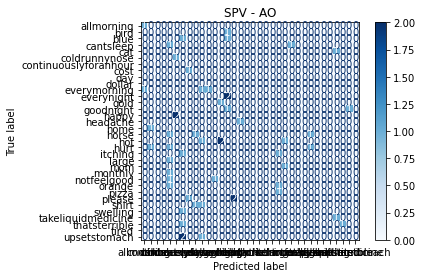

            GXL         GXL        GXL  ...       OYR       OYR       OYR
116    0.151124    0.259652   -3.67623  ... -0.721345 -0.721345 -0.721345
30     0.284159   -0.115257  -0.363574  ...   1.56089   1.40638   1.25187
120   -0.138911    0.128579 -0.0705069  ...   -0.3357   -0.3357   -0.3357
53  -0.00466915 -0.00113494   -1.64101  ... -0.362646 -0.242763 -0.242763
124   0.0347664   0.0162279  0.0404086  ... -0.705281 -0.705281 -0.705281
..          ...         ...        ...  ...       ...       ...       ...
64   -0.0467539  -0.0767813  -0.083454  ...   1.48616   1.48616   1.45821
153  -0.0453915  -0.0234121  0.0107781  ... -0.165227 -0.224027 -0.224027
5    -0.0470438   -0.118705 -0.0903107  ...   2.18653  -2.55183  -2.55183
47    -0.941443   -0.765879  -0.657267  ...   1.86597   1.86597   1.83866
143    0.314024    0.358241    0.90839  ...   2.41839   2.29522   2.22132

[122 rows x 600 columns]
4392


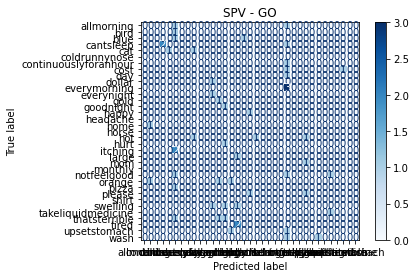

          EMG0L        EMG0L      EMG0L  ...         GZR        GZR        GZR
61   -0.0225832  0.000687108  -0.219227  ...     1.17626    0.88826  -0.473916
171   -0.044352   0.00134944   0.533708  ...    -1.09153  -0.958136   -0.78608
161   0.0356256  -0.00108393  0.0577883  ...   0.0166254  0.0395655   0.083031
120   0.0295758 -0.000899862 -0.0810005  ...    0.403215 -0.0592765 -0.0705069
159  0.00188216  -5.7266e-05 -0.0567516  ...  0.00743119   0.010013   0.010013
..          ...          ...        ...  ...         ...        ...        ...
54     0.100398  -0.00305467  -0.347454  ...    -0.19344  -0.360867  -0.384121
89    0.0746453  -0.00227113  -0.149806  ...    -1.79162   -2.18803   -1.90102
20    0.0866718  -0.00263704  -0.167159  ...  0.00749672  0.0115582  0.0125736
160 -0.00567839  0.000172769   0.494072  ...     -1.5387   -1.66729    -1.2065
76    0.0806779  -0.00245467   0.497183  ...  -0.0386961 -0.0448974 -0.0617294

[122 rows x 1400 columns]
10980


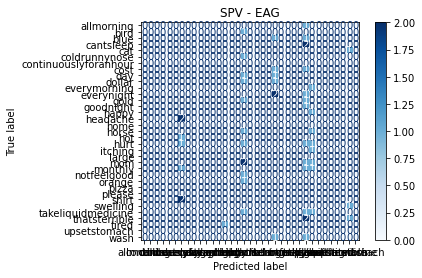

          EMG0L        EMG0L      EMG0L  ...        OYR        OYR        OYR
171   -0.044352   0.00134944   0.533708  ...    -1.6275    -1.6538   -1.70642
66     0.125384   -0.0038149  0.0553175  ...  -0.730929  -0.730929  -0.730929
37    0.0334565  -0.00101793  -0.100223  ...    1.31422    1.28275    1.28275
170   0.0450434  -0.00137047  -0.099246  ...    2.52625    2.52625    2.50221
94    0.0205776 -0.000626086  -0.143514  ...   -1.80304   -1.80304    2.12154
..          ...          ...        ...  ...        ...        ...        ...
138   0.0464866  -0.00141438  -0.280187  ...   0.654992   0.240939  -0.113963
24    0.0820024  -0.00249497  -0.119498  ...  -0.853256  -0.853256  -0.853256
115   0.0176388 -0.000536671  -0.684959  ...  0.0122202  0.0122202  0.0122202
159  0.00188216  -5.7266e-05 -0.0567516  ...   -1.70996   -1.70996   -1.70996
39    0.0189472  -0.00057648 -0.0820831  ...   -1.56947   -1.56947   -1.56947

[122 rows x 1400 columns]
10614


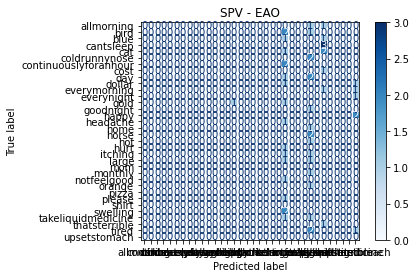

         EMG0L        EMG0L      EMG0L  ...         OYR        OYR        OYR
31   0.0259872 -0.000790677  -0.369398  ...     1.51121    1.40842    1.25423
151  0.0408784  -0.00124375  -0.162326  ...    0.652709   0.652709   0.652709
102  0.0349504  -0.00106339  -0.266804  ...    -1.41117   -1.41117   -1.41117
120  0.0295758 -0.000899862 -0.0810005  ...     -0.3357    -0.3357    -0.3357
55   0.0492295  -0.00149784   0.134691  ...   0.0987574  0.0987574  0.0987574
..         ...          ...        ...  ...         ...        ...        ...
148  0.0377321  -0.00114802 -0.0569878  ...    -0.96969   -0.96969   -0.96969
152  0.0373253  -0.00113564 -0.0767124  ... -0.00792115  -0.063185  -0.063185
103  0.0802566  -0.00244186  -0.507204  ...    -1.82734   -1.82734   -1.82734
127  0.0263728 -0.000802407 -0.0520751  ...     1.91718    1.91718    1.89196
25   0.0346725  -0.00105493  -0.146144  ...   -0.305059  -0.305059  -0.358988

[122 rows x 1400 columns]
10736


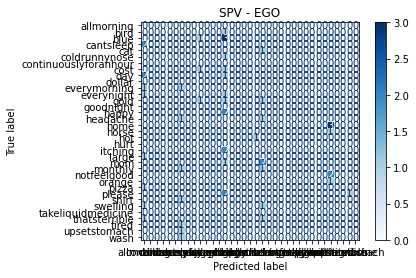

          AXL        AXL       AXL  ...        OYR        OYR          OYR
141  0.529547   0.748987   1.29962  ...   0.472059   0.497032     0.497032
98  -0.823293  -0.965931   -1.2694  ...  -0.357477  -0.357477    -0.357477
29   -1.33169   -1.28392  -1.31292  ...   -1.52449   -1.52449     -1.52449
28   -1.20375   -1.19704  -1.18025  ...   -1.49869   -1.49869     -1.49869
61   0.454715   0.447149  0.449039  ...    -1.8171    -1.8171      -1.8171
..        ...        ...       ...  ...        ...        ...          ...
115  0.065736  0.0925309  0.143978  ...  0.0122202  0.0122202    0.0122202
121 -0.779256   -0.75963 -0.774584  ...   0.460779 -0.0594833    -0.423667
55    0.44491   0.575265  0.623709  ...  0.0987574  0.0987574    0.0987574
22  -0.803934  -0.820149 -0.818122  ...  0.0400347  0.0400347 -0.000133895
72   0.790333   0.692859 -0.132986  ...   -1.97271   -1.97271     -1.97271

[122 rows x 900 columns]
4880


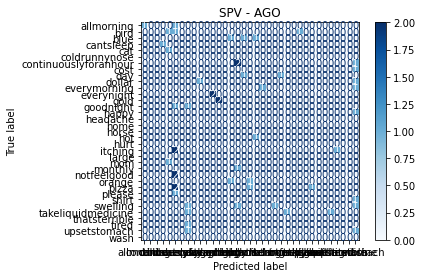

          EMG0L        EMG0L       EMG0L  ...       OYR       OYR       OYR
30    0.0741488  -0.00225602    -1.10711  ...   1.56089   1.40638   1.25187
173    0.125913  -0.00383099   -0.294745  ... -0.956788 -0.956788 -0.956788
48    0.0941077  -0.00286328  -0.0491875  ...     2.045   2.01787   1.99074
16    0.0133251 -0.000405423   0.0958655  ...  -0.26368 -0.319074 -0.429864
38    0.0194634 -0.000592185  -0.0964372  ...   1.34226   1.31065   1.31065
..          ...          ...         ...  ...       ...       ...       ...
132   0.0691267  -0.00210322  -0.0361306  ...   1.17803   1.11317   1.11317
102   0.0349504  -0.00106339   -0.266804  ...  -1.41117  -1.41117  -1.41117
72   -0.0182734   0.00055598    0.225805  ...  -1.97271  -1.97271  -1.97271
71    0.0417021  -0.00126881   -0.123046  ...  -1.92214  -1.92214  -1.92214
58  -0.00879783  0.000267679  0.00459838  ...  -1.27985  -1.27985  -1.27985

[122 rows x 1700 columns]
10614


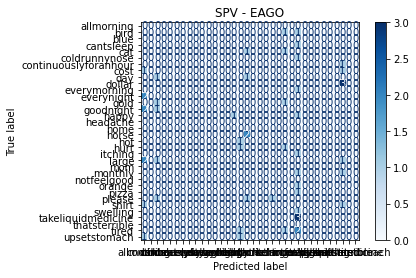

    EMG0L EMG0L     EMG0L      EMG0L  ...      EMG7R     EMG7R      EMG7R     EMG7R
140     0     0  -2.13591    5.11375  ...  -0.728711  -1.13414   0.136439   2.68579
108     0     0   3.55984   -8.40426  ...    2.13854   1.05179  -0.288474   3.63359
114     0     0 -0.711968  0.0433241  ...   -7.71387  -3.35616    1.22916 -0.771453
126     0     0 -0.711968   0.755293  ...    9.76618  -7.11256   -11.0726  -5.33127
121     0     0 -0.711968   0.755293  ...    3.19051  0.103826    7.91275   21.9861
..    ...   ...       ...        ...  ...        ...       ...        ...       ...
125     0     0         0  -0.355984  ...    12.2782   10.0382    5.77939   8.80726
127     0     0 -0.355984   0.733631  ...    4.34644  -8.57231    3.06299  -4.18059
130     0     0 -0.711968   0.755293  ...  0.0263014  -5.32307   -4.29117  -6.12885
33      0     0   1.42394   -1.51059  ...    12.8256   14.0375    3.84281   12.5719
143     0     0  0.355984   -2.51355  ...    2.23146   2.85627 -0.0662316 -0

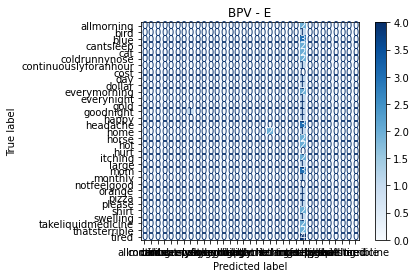

           AXL        AXL        AXL  ...       AZR       AZR       AZR
164   0.474121    0.55127   0.610352  ...  0.773926  0.771484  0.765137
34   -0.703125  -0.730957  -0.668457  ...  0.602051  0.650879  0.672363
88  -0.0869141 -0.0947266  -0.104492  ...   1.47266  0.947266   1.06592
101  -0.369141  -0.328613  -0.375488  ...   0.84375  0.805664  0.889648
66   -0.184082  -0.163086  -0.109863  ...  0.886719  0.889648  0.883789
..         ...        ...        ...  ...       ...       ...       ...
98   -0.121582  -0.194336  -0.349121  ...   1.13623  0.934082   1.02588
145  -0.567871   -0.27832   0.259277  ...   1.01074   0.98291   1.00781
12  -0.0493164 -0.0493164 -0.0522461  ...  0.861816  0.937988   1.01416
28   -0.537109  -0.533203  -0.523438  ...  0.829102  0.824219  0.830566
14    -0.75293  -0.731445  -0.674316  ...   0.84082  0.890625  0.893555

[122 rows x 300 columns]
2806


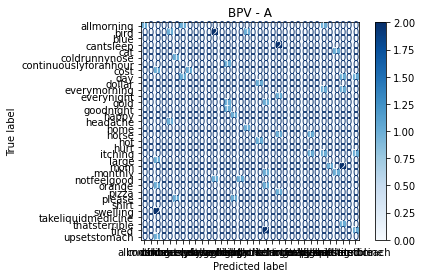

         GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
41  -39.8125  -24.375 -44.8125    -51.5  ...  16.8125    1.625    -12.5 -58.9375
172    2.625 -47.8125  -15.375     -9.5  ...  -3.0625  -6.3125  -4.1875        3
165  -0.5625   -1.625   16.375  21.5625  ... -114.812 -79.5625  -48.875   -9.375
153   -4.875    -3.75       -2   0.5625  ...   -6.125   7.0625   11.625 -24.6875
97  -36.8125  -118.25  -154.25  -145.75  ...   2.9375   0.3125        1  -1.3125
..       ...      ...      ...      ...  ...      ...      ...      ...      ...
144    7.625      -66 -105.062 -87.6875  ...    -27.5      -22    6.625   2.1875
96   225.438   173.75  184.875  145.562  ...  -0.0625  -1.3125  -1.1875   0.1875
58  -33.6875 -58.6875 -45.0625     6.75  ...  -8.1875  -1.3125   1.0625  -0.3125
140  -55.125      -72  -22.875 -23.3125  ...  -17.875 -14.5625 -12.0625    -6.25
23   -1.3125  -2.0625  -0.6875  -0.6875  ... -13.9375 -26.8125 -51.8125  -74.125

[122 rows x 300 columns]
46

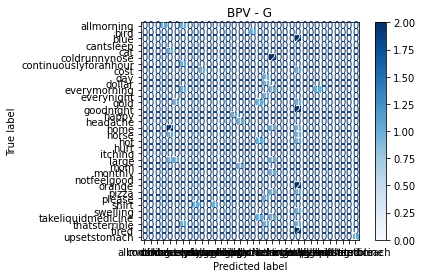

     ORL  ORL  ORL  ORL  ORL  ORL  ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR
57    82   81   81   82   87   91   96  ...   20   20   20   20   20   20   20
61    84   84   84   84   84   84   84  ...    7    8    9   10   11   11   11
10   104  104  104  104  104  104  104  ...   44   44   45   44   44   43   43
157   84   84   83   83   83   83   83  ...   96   96   96   96   95   95   95
146   80   81   81   80   79   78   75  ...   78   78   78   78   78   78   78
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
141   71   72   81   86   91   88   88  ...   90   91   91   92   92   93   93
107   75   75   73   73   71   69   69  ...   43   44   46   48   48   49   49
143   63   63   66   70   76   81   86  ...    1  179  177  174  170  165  162
84    79   79   79   79   79   79   79  ...   40   36   32   29   28   27   26
30    76   76   76   72   71   73   75  ...  109  108  108  107  106  103  100

[122 rows x 300 columns]
1708


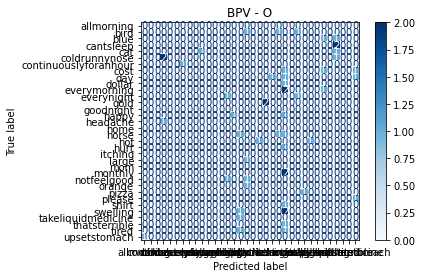

    EMG0L    EMG0L     EMG0L      EMG0L  ...       AZR       AZR       AZR       AZR
149     0        0  0.711968   -3.60317  ...  0.837402  0.843262  0.844727  0.836426
28      0        0  -2.49189    5.84738  ...   0.83252  0.829102  0.824219  0.830566
141     0        0 -0.711968   0.755293  ...  0.770996  0.824219   1.16602   0.61084
42      0        0         0   0.355984  ...  0.820801   0.78418   0.78125   0.71582
134     0        0 -0.355984   0.377646  ...   1.01416  0.640625  0.603516  0.792969
..    ...      ...       ...        ...  ...       ...       ...       ...       ...
132     0        0         0          0  ...  0.990723    1.0835   1.14209    1.0791
140     0        0  -2.13591    5.11375  ...    1.0459  0.805176  0.747559  0.825195
15      0 -3.20386   3.04283 -0.0309844  ...   0.46875  0.459961  0.492188  0.526855
118     0        0  0.355984   -2.51355  ...  0.630371  0.730957  0.817871  0.862305
26      0        0 -0.355984  -0.334322  ...  0.936035  0.957031 

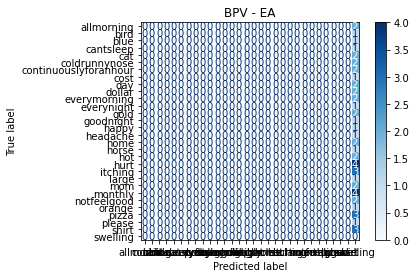

    EMG0L EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR      GZR
4       0     0  -2.84787   5.51306  ... -14.1875  -3.3125    -0.75     -9.5
9       0     0  -1.06795   1.84491  ...    2.125  -0.0625     0.25     3.25
122     0     0  -1.06795   1.84491  ... -162.938 -66.1875 -31.1875 -35.4375
141     0     0 -0.711968  0.755293  ...  -33.875    -29.5 -26.0625   -23.25
72      0     0   3.55984  -3.42048  ...   -1.125  -0.3125    3.875   2.3125
..    ...   ...       ...       ...  ...      ...      ...      ...      ...
55      0     0   1.42394  -4.00247  ...    0.125        1      0.5  -0.3125
20      0     0 -0.355984  0.733631  ...   -0.375  -0.3125  -0.0625        0
88      0     0 -0.355984  0.733631  ...   -42.75  -32.625   -16.25  -7.3125
129     0     0 -0.355984  0.377646  ...  -28.875  14.6875   -7.125   0.1875
138     0     0  -2.13591   4.40178  ... -105.875 -112.188 -165.375 -160.125

[122 rows x 1100 columns]
6222


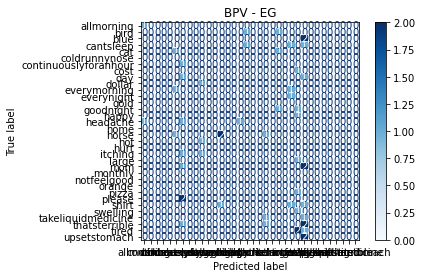

    EMG0L EMG0L     EMG0L    EMG0L      EMG0L  ... OYR OYR OYR OYR OYR
101     0     0 -0.711968  1.46726 -0.0550234  ...  69  68  68  67  67
73      0     0  -1.42394  3.64649    2.33852  ...  16  16  16  16  17
120     0     0 -0.711968  1.46726  -0.766992  ...  81  81  81  81  81
54      0     0  -2.49189   5.4914   -3.06212  ...  81  83  84  85  86
119     0     0   2.13591 -7.24966    4.96616  ...  44  44  44  44  43
..    ...   ...       ...      ...        ...  ...  ..  ..  ..  ..  ..
29      0     0  -1.06795  3.26884   -3.35138  ...  14  14  14  14  14
164     0     0  -3.20386  5.17874    1.26298  ...  30  30  30  30  30
115     0     0  -6.05173  10.3358   -3.89757  ...  82  82  82  82  82
106     0     0  -4.27181 -25.3709    84.6937  ...   0   5   7   8   9
49      0     0  0.355984  3.89416   -7.72976  ...  54  54  54  53  53

[122 rows x 1100 columns]
6954


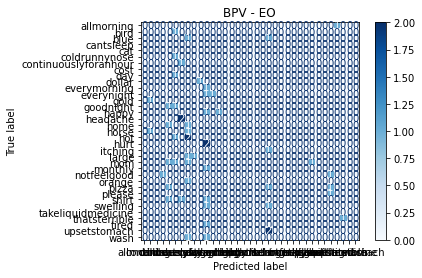

           AXL        AXL       AXL  ...      GZR      GZR      GZR
87   -0.480957  -0.491699 -0.510254  ...    -63.5  -34.125 -30.0625
102 -0.0268555 -0.0449219 -0.116211  ...  11.0625     1.75  -0.3125
134  -0.615723  -0.631348 -0.636719  ...   2.5625   -8.375   5.4375
124  -0.574707  -0.575684  -0.62793  ...   1.1875  -0.8125  -0.6875
109   0.668457   0.678711   0.70752  ...     6.25     2.75   0.1875
..         ...        ...       ...  ...      ...      ...      ...
107  -0.176758  -0.161621 -0.231934  ...  63.8125  45.5625       43
155  -0.206055  -0.197266 -0.179688  ...  -0.9375  -0.4375   0.0625
171   0.248535   0.214355  0.244141  ... -63.6875 -55.0625 -43.9375
169  -0.370605  -0.370605 -0.368164  ... -122.938    -88.5   -64.25
8     -0.17041  -0.166016 -0.165527  ... -129.438 -131.688   -118.5

[122 rows x 600 columns]
4514


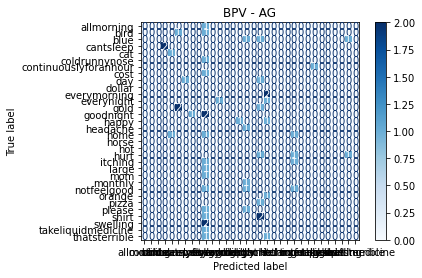

          AXL       AXL        AXL       AXL       AXL  ...  OYR  OYR  OYR  OYR  OYR
130 -0.666992 -0.661133  -0.663574 -0.663086 -0.656738  ...  173  170  167  164  163
169 -0.370605 -0.370605  -0.368164 -0.370117    -0.375  ...   34   31   28   23   20
3    0.314941  0.170898   0.319824  0.337891  0.396973  ...   23   23   23   23   23
46   -0.23877 -0.245117   0.118652  0.344238  0.395996  ...   74   74   74   74   74
139 -0.680176 -0.679199  -0.646484 -0.679688 -0.676758  ...   91   91   90   91   91
..        ...       ...        ...       ...       ...  ...  ...  ...  ...  ...  ...
133  -0.21582 -0.215332  -0.209961 -0.201172 -0.202148  ...   78   79   79   79   79
146 -0.215332 -0.238281  -0.211914 -0.202148 -0.223145  ...   78   78   78   78   78
57  -0.292969 -0.288574   0.106934  0.158203  0.283691  ...   20   20   20   20   20
96  -0.226562 -0.117188  0.0805664  0.166016  0.230469  ...   89   89   89   89   89
136 -0.654785 -0.656738  -0.665039 -0.660156 -0.657227  ...    7 

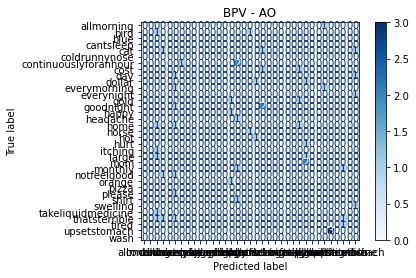

         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
111   -1.125   -0.125    2.375        3   -0.375  ...  130  130  130  130  130
57  -21.6875  -9.5625  11.8125   27.125  36.4375  ...   20   20   20   20   20
3   -126.812 -138.125   20.875   6.9375 -38.5625  ...   23   23   23   23   23
42    -45.25 -11.8125  -8.5625   -37.75  33.8125  ...   89   89   89   89   89
28   -0.6875      0.5    4.875    4.625   5.6875  ...   16   16   16   16   16
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
156  -20.625 -11.4375       14   22.375     20.5  ...  101  101  101  100  100
96   225.438   173.75  184.875  145.562  97.5625  ...   89   89   89   89   89
77  -53.4375     -193  102.875  54.6875 -105.688  ...   74   74   74   74   74
99   134.188   207.75  191.812  171.125  171.125  ...  160  161  161  161  161
19  -22.6875 -47.0625  17.5625    4.875  -40.375  ...    3    2    1    1    1

[122 rows x 600 columns]
4758


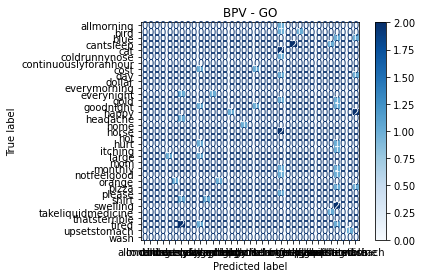

    EMG0L EMG0L     EMG0L     EMG0L  ...      GZR      GZR     GZR      GZR
60      0     0  -1.42394   3.29051  ...    8.375     6.25  -1.125  -0.1875
29      0     0  -1.06795   3.26884  ...   -16.25   4.6875      -9  -4.6875
159     0     0 -0.355984  0.377646  ...        0   -0.875   -0.75    -0.75
33      0     0   1.42394  -1.51059  ...  -157.75 -133.062 -112.75 -65.1875
148     0     0 -0.355984   1.08961  ...   -6.625  -7.8125       3  -3.5625
..    ...   ...       ...       ...  ...      ...      ...     ...      ...
24      0     0 -0.355984  0.733631  ...     -4.5   1.3125  1.6875  -4.4375
157     0     0  0.711968  -1.11128  ...     4.25  -6.5625   -6.75   1.9375
118     0     0  0.355984  -2.51355  ...  -67.125  -34.625  3.4375    36.25
168     0     0         0   2.13591  ... -17.1875 -41.1875   -83.5 -87.8125
87      0     0 -0.355984  0.733631  ... -107.875    -63.5 -34.125 -30.0625

[122 rows x 1400 columns]
6466


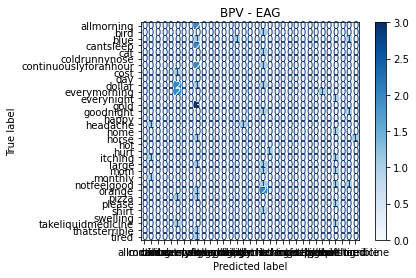

    EMG0L EMG0L     EMG0L      EMG0L      EMG0L  ...  OYR  OYR  OYR  OYR  OYR
39      0     0 -0.711968    2.17923   -2.59024  ...   20   20   20   20   20
52      0     0         0   -1.42394     1.1546  ...   80   80   80   80   80
75      0     0   9.25559   -15.5146   -15.1646  ...   79   79   78   78   78
169     0     0 -0.355984   0.733631  -0.383496  ...   34   31   28   23   20
76      0     0   2.13591    -6.1817    4.54519  ...   73   74   74   74   74
..    ...   ...       ...        ...        ...  ...  ...  ...  ...  ...  ...
95      0     0 -0.711968    2.17923   -2.23425  ...  121  122  122  121  121
118     0     0  0.355984   -2.51355    5.47559  ...  105  102  100   99  100
3       0     0 -0.711968    1.46726 -0.0550234  ...   23   23   23   23   23
80      0     0 -0.355984  0.0216621   0.727781  ...  128  126  125  124  124
86      0     0         0  -0.355984   0.377646  ...  129  125  124  123  123

[122 rows x 1400 columns]
6832


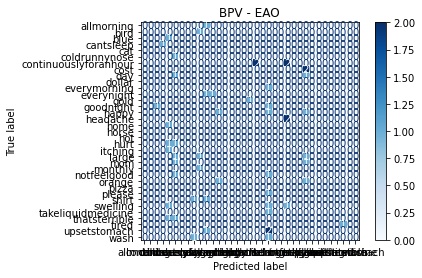

    EMG0L EMG0L     EMG0L    EMG0L      EMG0L     EMG0L  ... OYR OYR OYR OYR OYR OYR
55      0     0   1.42394 -4.00247    2.31094  -1.52633  ...  83  83  83  83  83  83
62      0     0 -0.355984  1.08961  -0.405158  -1.68011  ...  64  64  65  66  66  66
75      0     0   9.25559 -15.5146   -15.1646   26.8308  ...  79  79  79  78  78  78
164     0     0  -3.20386  5.17874    1.26298  -1.31365  ...  30  30  30  30  30  30
51      0     0  0.355984 -3.22552    2.31505   7.71841  ...  87  85  84  83  83  83
..    ...   ...       ...      ...        ...       ...  ...  ..  ..  ..  ..  ..  ..
100     0     0  -1.06795  2.55688   -1.52813   1.06469  ...  67  67  67  67  67  67
3       0     0 -0.711968  1.46726 -0.0550234  -0.88003  ...  24  23  23  23  23  23
11      0     0  -1.77992  4.02414   -1.22717 -0.904957  ...  78  78  78  78  78  78
171     0     0   2.13591 -4.75777   0.186732   3.01189  ...  15  11   9   6   5   3
103     0     0  -2.13591  4.75777  -0.898701  -3.68053  ...  67 

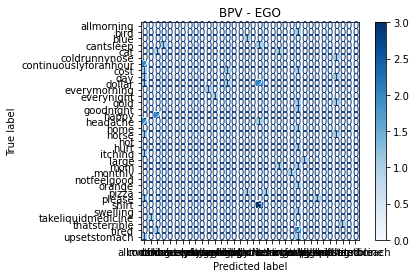

           AXL        AXL         AXL       AXL  ...  OYR  OYR  OYR  OYR
2    -0.245605  -0.226074  -0.0908203  0.131348  ...   22   22   22   22
134  -0.615723  -0.631348   -0.636719 -0.638672  ...  176  177  177  177
101  -0.369141  -0.328613   -0.375488 -0.310547  ...   68   68   67   67
144  -0.577148  -0.625488    -0.65332 -0.513672  ...   86   86   86   86
34   -0.703125  -0.730957   -0.668457 -0.699219  ...   42   41   39   37
..         ...        ...         ...       ...  ...  ...  ...  ...  ...
30   -0.344727  -0.362305 -0.00830078  0.225586  ...  107  106  103  100
25   -0.199707  -0.199707   -0.206543 -0.201172  ...   80   80   80   79
174 -0.0712891 -0.0649414   0.0112305  0.145996  ...  178  178  177  177
142 -0.0649414   0.065918    0.145996  0.177734  ...  176  173  168  165
42   -0.203125 -0.0610352    0.295898  0.242188  ...   89   89   89   89

[122 rows x 900 columns]
4758


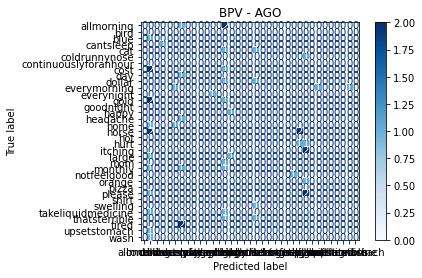

    EMG0L    EMG0L     EMG0L     EMG0L       EMG0L  ...  OYR  OYR  OYR  OYR  OYR
101     0        0 -0.711968   1.46726  -0.0550234  ...   69   68   68   67   67
134     0        0 -0.355984  0.377646 -0.00584961  ...  176  176  177  177  177
121     0        0 -0.711968  0.755293     1.41224  ...  106  102   97   87   80
158     0        0 -0.711968   1.82325    -2.56857  ...   98   98   98   98   98
138     0        0  -2.13591   4.40178   -0.521054  ...  102   97   93   86   80
..    ...      ...       ...       ...         ...  ...  ...  ...  ...  ...  ...
168     0        0         0   2.13591    -3.68981  ...  123  124  124  123  121
96      0  1.06795  -5.76073   6.35089     2.71184  ...   89   89   89   89   89
95      0        0 -0.711968   2.17923    -2.23425  ...  121  122  122  121  121
27      0        0  0.711968  -2.17923    0.454332  ...   83   83   83   82   82
154     0        0 -0.355984  0.377646 -0.00584961  ...   44   39   37   34   33

[122 rows x 1700 columns]
6

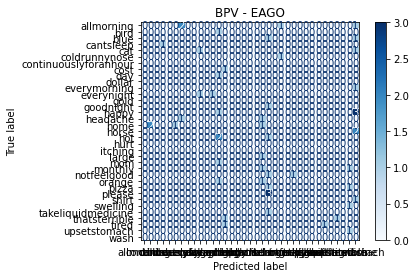

        EMG0L     EMG0L     EMG0L  ...        EMG7R        EMG7R       EMG7R
62   0.163753 -0.173717 -0.164622  ...  -0.00652527   -0.0158562  -0.0397894
33   0.177992 -0.188823 -0.168413  ...    0.0655957    0.0179571   0.0587473
104  0.210031 -0.222811 -0.210139  ...    0.0624092     0.123105  -0.0728214
102  0.159256 -0.168947 -0.166007  ...  -0.00901702   -0.0348907  -0.0269945
38   0.187543 -0.198955 -0.187934  ...  -0.00873196    0.0168662 -0.00607553
..        ...       ...       ...  ...          ...          ...         ...
143   0.17869 -0.189564 -0.174358  ...    0.0112011 -0.000259732 -0.00221641
97   0.215953 -0.229093 -0.215778  ... -0.000615194  -0.00286756   0.0109011
68   0.175295 -0.185962 -0.140053  ...  -0.00750576  -0.00232345 -0.00276589
156  0.213591 -0.226588 -0.208103  ...  -0.00763315    0.0077618  0.00335718
139  0.193076 -0.204825  -0.19292  ...   -0.0199043   -0.0196338  -0.0155647

[122 rows x 800 columns]
10492


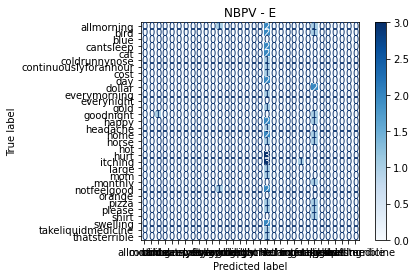

          AXL        AXL        AXL  ...       AZR       AZR       AZR
46   0.221328   0.218422   0.384977  ...  0.795442  0.796335  0.794101
96   0.370957   0.410338    0.48154  ...  0.757032  0.758615  0.756153
162  0.107831  0.0807954  0.0981977  ...  0.866376  0.863268  0.868551
116  0.249322   0.231416   0.213511  ...  0.942216  0.886871  0.810635
7    0.117806   0.133993   0.125899  ...  0.655575  0.620503  0.597721
..        ...        ...        ...  ...       ...       ...       ...
143  0.549815   0.583573   0.636064  ...  0.692672  0.690819  0.716962
112  0.220329   0.215582   0.219212  ...         1  0.789723  0.827422
145  0.109946    0.24521   0.496351  ...    0.8474  0.834399  0.846031
160   0.15258   0.139601   0.109528  ...  0.775878  0.849953  0.892686
139  0.152685   0.153083   0.166403  ...  0.712326  0.684891   0.69503

[122 rows x 300 columns]
2440


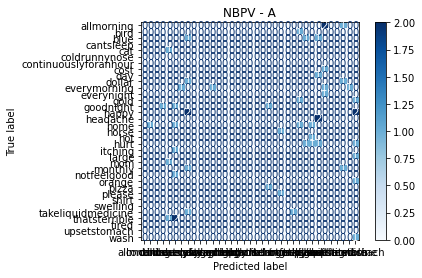

          GXL       GXL       GXL  ...       GZR       GZR        GZR
6    0.553448  0.542948  0.551803  ...   0.32119  0.395446   0.439216
142  0.570679  0.577403  0.557724  ...   0.30469  0.270416   0.248113
126  0.506394  0.513024  0.511603  ...   0.49775   0.50592   0.513024
88   0.541536  0.541045   0.53531  ...  0.453219  0.496149    0.51958
4    0.530036  0.389343  0.448545  ...  0.504265  0.511405   0.487027
..        ...       ...       ...  ...       ...       ...        ...
86   0.388626  0.388626  0.404832  ...  0.343622  0.380472   0.402148
146  0.572534  0.555426  0.446919  ...  0.484182  0.482541   0.484416
153  0.388463  0.390977  0.394888  ...  0.415142  0.425339   0.344183
1    0.233108  0.247087  0.301042  ...  0.216063  0.121153  0.0456162
45   0.526861  0.618106  0.511937  ...  0.471005  0.466173   0.452387

[122 rows x 300 columns]
4270


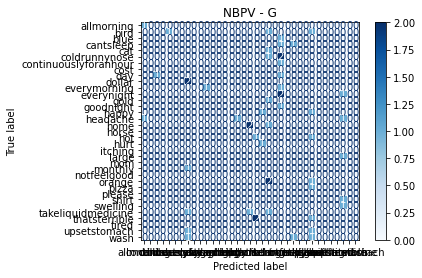

           ORL        ORL        ORL  ...        OYR        OYR        OYR
86    0.252033   0.252033   0.252033  ...   0.569106   0.560976   0.560976
64    0.166667   0.166667   0.166667  ...   0.833333   0.833333   0.826087
111   0.212598   0.212598   0.212598  ...   0.748031   0.748031   0.748031
8    0.0743802  0.0743802  0.0743802  ...   0.793388   0.768595   0.743802
116   0.694915   0.694915   0.644068  ...   0.372881   0.372881   0.372881
..         ...        ...        ...  ...        ...        ...        ...
152   0.450704   0.450704   0.450704  ...    0.56338   0.549296   0.549296
81    0.824176   0.824176   0.824176  ...   0.021978   0.021978   0.021978
102   0.462687   0.462687   0.477612  ...   0.179104   0.179104   0.179104
101    0.22449   0.244898   0.265306  ...  0.0408163  0.0204082  0.0204082
79    0.648148    0.62963   0.611111  ...   0.648148   0.648148   0.648148

[122 rows x 300 columns]
1586


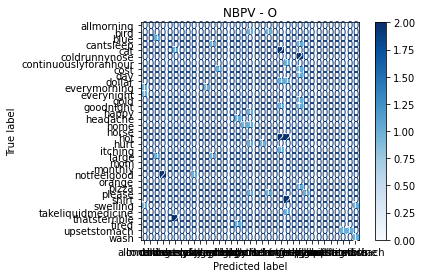

        EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR
79   0.210852 -0.223683 -0.234771  ...  0.787317  0.848246  0.865687
45   0.135028 -0.143245 -0.135879  ...  0.689714  0.683394  0.699674
64   0.166594 -0.176731  -0.16561  ...   0.88945  0.878588  0.837555
46   0.173129 -0.183664 -0.191682  ...  0.795442  0.796335  0.794101
83   0.169902  -0.18024   -0.1752  ...  0.827075  0.860026  0.917497
..        ...       ...       ...  ...       ...       ...       ...
69   0.247211 -0.262254 -0.253037  ...  0.870316  0.868775  0.866206
89   0.199991 -0.212161 -0.200705  ...  0.731055  0.760467  0.813557
152  0.163601 -0.173557 -0.163943  ...  0.825349   0.76628  0.753256
132  0.222031 -0.235542 -0.218383  ...  0.806041  0.830853  0.804178
110  0.202142 -0.214442  -0.19882  ...  0.509839   0.49227  0.494203

[122 rows x 1100 columns]
8052


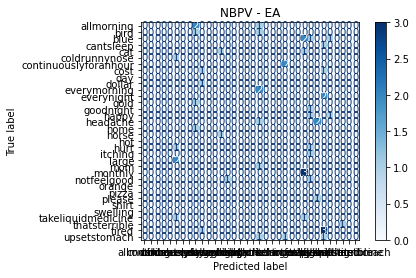

        EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
36   0.154776 -0.164194 -0.155328  ...    0.3949  0.395153  0.394648
132  0.222031 -0.235542 -0.218383  ...  0.137056  0.271509  0.317327
152  0.163601 -0.173557 -0.163943  ...  0.412196  0.280939  0.338822
23   0.188462  -0.19993 -0.185365  ...  0.308444  0.228588  0.157317
34   0.183897 -0.195087 -0.158943  ...  0.429232  0.385825  0.342858
..        ...       ...       ...  ...       ...       ...       ...
166  0.162287 -0.172162 -0.171835  ...  0.013967  0.162949  0.259554
64   0.166594 -0.176731  -0.16561  ...  0.398075  0.391732  0.391732
43    0.14058 -0.149134 -0.140537  ...  0.281557  0.277485  0.279521
89   0.199991 -0.212161 -0.200705  ...  0.396575  0.348861  0.383407
141   0.19716 -0.209158 -0.197572  ...  0.469924  0.479063   0.48654

[122 rows x 1100 columns]
9394


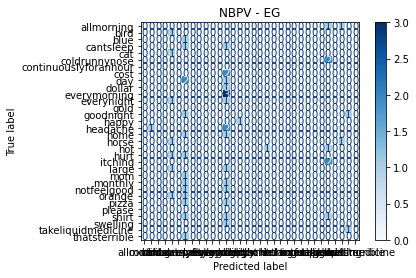

        EMG0L     EMG0L      EMG0L  ...        OYR        OYR        OYR
46   0.173129 -0.183664  -0.191682  ...   0.466667   0.466667   0.466667
63   0.162194 -0.172064  -0.161635  ...   0.829787   0.829787   0.822695
108  0.166767 -0.176915  -0.131956  ...   0.505882   0.505882   0.505882
168  0.174634  -0.18526  -0.171764  ...          1   0.980392   0.941176
147  0.166561 -0.176697  -0.163824  ...   0.314286        0.3        0.3
..        ...       ...        ...  ...        ...        ...        ...
111   0.14714 -0.156094  -0.154215  ...   0.748031   0.748031   0.748031
163  0.204223  -0.21665  -0.213982  ...   0.023622   0.023622   0.023622
70   0.154958 -0.164387  -0.146129  ...   0.814815   0.796296   0.787037
173  0.209843 -0.222613  -0.217637  ...   0.348485   0.348485   0.348485
18   0.197769 -0.209803 -0.0654489  ...  0.0252101  0.0252101  0.0252101

[122 rows x 1100 columns]
5368


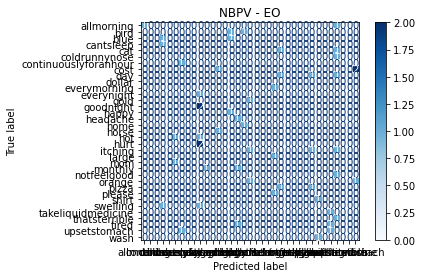

           AXL        AXL        AXL  ...       GZR       GZR       GZR
96    0.370957   0.410338    0.48154  ...  0.616019  0.616211  0.618322
128   0.381463   0.373839   0.375745  ...  0.281285  0.277903  0.236941
47    0.565042   0.555868   0.555162  ...  0.274786   0.29095  0.370907
58    0.123167    0.10641   0.110599  ...  0.529939  0.533603  0.531482
162   0.107831  0.0807954  0.0981977  ...  0.501573  0.492887  0.488543
..         ...        ...        ...  ...       ...       ...       ...
117  0.0922731  0.0747686   0.105526  ...  0.490705  0.447335  0.425804
11    0.173409   0.168435   0.180703  ...  0.538737  0.538737  0.538737
113   0.195664   0.199187   0.194039  ...  0.496999  0.505599  0.492456
116   0.249322   0.231416   0.213511  ...  0.487979  0.519686  0.559756
41    0.309713   0.270285   0.343999  ...  0.499248  0.465293  0.353665

[122 rows x 600 columns]
4392


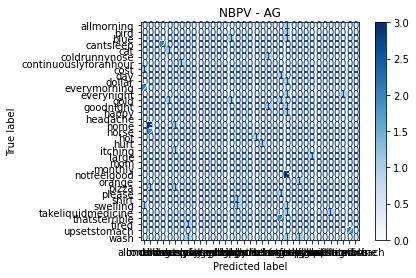

            AXL         AXL         AXL  ...       OYR       OYR        OYR
93     0.798156    0.799435    0.810179  ...         1         1   0.994413
112    0.220329    0.215582    0.219212  ...  0.355263  0.342105   0.342105
105    0.478649    0.482192    0.485735  ...  0.994318         0  0.0227273
130  0.00359531  0.00667677  0.00539296  ...  0.932961  0.916201   0.910615
120    0.379628    0.386852    0.461803  ...  0.534247  0.534247   0.534247
..          ...         ...         ...  ...       ...       ...        ...
100    0.114396    0.123515    0.109975  ...         0         0          0
124    0.133511     0.13313     0.11278  ...  0.351562  0.351562   0.351562
129    0.432804    0.431912    0.431198  ...         0         0          0
160     0.15258    0.139601    0.109528  ...  0.868687  0.848485   0.838384
43     0.533256      0.5365    0.540208  ...  0.988827  0.977654   0.960894

[122 rows x 600 columns]
2440


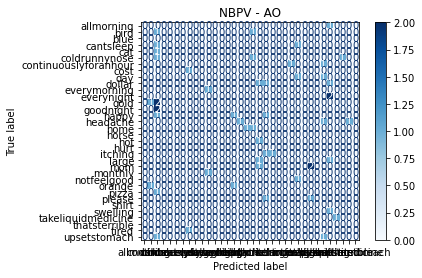

          GXL       GXL       GXL  ...       OYR       OYR        OYR
120  0.391871  0.432516  0.402265  ...  0.534247  0.534247   0.534247
11   0.553558  0.549516  0.559846  ...  0.464286  0.464286   0.464286
14   0.454875  0.444461  0.441594  ...  0.234568  0.259259   0.271605
57   0.560849  0.576866  0.605102  ...  0.101695  0.101695   0.101695
146  0.572534  0.555426  0.446919  ...  0.326087  0.326087   0.326087
..        ...       ...       ...  ...       ...       ...        ...
170  0.455685    0.4483  0.485916  ...  0.988764  0.988764   0.983146
105  0.403588  0.425074  0.435817  ...  0.994318         0  0.0227273
167  0.383351  0.369374   0.40144  ...  0.836735  0.755102   0.693878
75    0.76825  0.510442   0.55184  ...  0.418367  0.418367   0.418367
58   0.479992  0.441423  0.462443  ...  0.101695  0.101695   0.101695

[122 rows x 600 columns]
3050


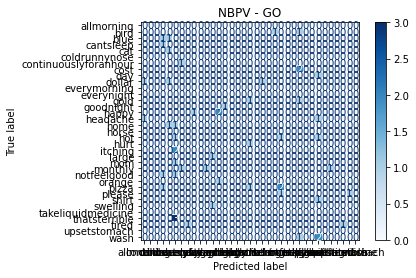

        EMG0L     EMG0L      EMG0L  ...       GZR        GZR       GZR
26   0.168371 -0.178616  -0.170415  ...  0.464001    0.47463  0.480831
134  0.176264  -0.18699  -0.176824  ...  0.499181   0.470511  0.506717
46   0.173129 -0.183664  -0.191682  ...       0.5   0.499252  0.501246
152  0.163601 -0.173557  -0.163943  ...  0.412196   0.280939  0.338822
124  0.177992 -0.188823  -0.179207  ...  0.469742   0.466634  0.466828
..        ...       ...        ...  ...       ...        ...       ...
50   0.208947 -0.221662  -0.226151  ...  0.475113   0.478052  0.475309
10   0.165225 -0.175279  -0.165514  ...  0.364261   0.436789  0.370947
12   0.147941 -0.156944  -0.150134  ...  0.219564  0.0988246         0
24   0.224046 -0.237679  -0.222854  ...  0.422056    0.42289  0.409262
65   0.151917 -0.161161 -0.0791306  ...  0.474931   0.477833  0.477188

[122 rows x 1400 columns]
8052


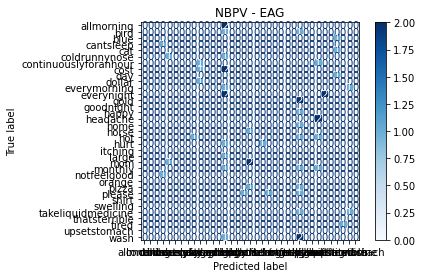

        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
137  0.228367 -0.242264 -0.227973  ...   0.128205   0.128205   0.128205
6    0.159579  -0.16929 -0.163095  ...   0.269565   0.252174   0.252174
95   0.173597 -0.184161  -0.17514  ...   0.731959   0.721649   0.721649
63   0.162194 -0.172064 -0.161635  ...   0.829787   0.829787   0.822695
38   0.187543 -0.198955 -0.187934  ...   0.756522   0.747826   0.747826
..        ...       ...       ...  ...        ...        ...        ...
85   0.158215 -0.167843  -0.15878  ...   0.544715   0.536585   0.536585
94   0.110803 -0.117546 -0.113697  ...          0          0          1
20   0.213591 -0.226588 -0.212624  ...   0.677686   0.677686   0.677686
72   0.169166  -0.17946 -0.151676  ...  0.0338983  0.0338983  0.0338983
135  0.186829 -0.198197 -0.188808  ...   0.897727   0.903409   0.903409

[122 rows x 1400 columns]
5246


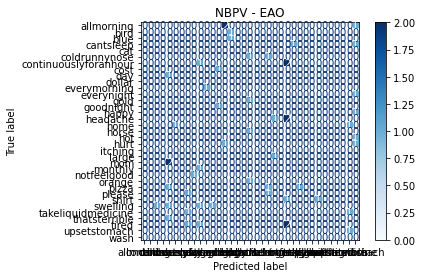

        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
119  0.214475 -0.227526 -0.197684  ...  0.0884354  0.0884354  0.0816327
80   0.166921 -0.177078 -0.165881  ...   0.590551   0.582677   0.582677
36   0.154776 -0.164194 -0.155328  ...    0.29703    0.29703    0.29703
138  0.150213 -0.159354 -0.160091  ...   0.698413   0.587302   0.492063
114  0.148327 -0.157353 -0.150834  ...   0.983146   0.983146   0.983146
..        ...       ...       ...  ...        ...        ...        ...
37   0.204253 -0.216682 -0.204787  ...   0.756522   0.747826   0.747826
56   0.152293  -0.16156 -0.125043  ...   0.653333   0.653333   0.653333
169  0.171454 -0.181887 -0.170089  ...   0.113475  0.0780142  0.0567376
39   0.190527 -0.202121 -0.190739  ...          0          0          0
24   0.224046 -0.237679 -0.222854  ...   0.321739   0.321739   0.321739

[122 rows x 1400 columns]
5978


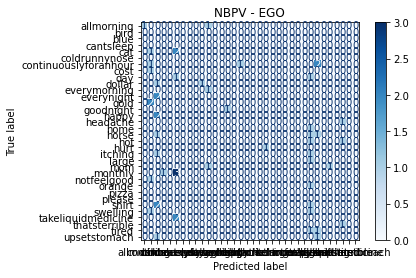

            AXL         AXL         AXL  ...         OYR         OYR         OYR
162    0.107831   0.0807954   0.0981977  ...        0.71        0.71        0.71
53     0.149696     0.15287    0.028035  ...    0.293103    0.327586    0.327586
108    0.517521    0.544268    0.588431  ...    0.505882    0.505882    0.505882
86     0.154735    0.154735    0.138643  ...    0.569106    0.560976    0.560976
150    0.360308    0.359826    0.334778  ...    0.929825    0.929825    0.929825
..          ...         ...         ...  ...         ...         ...         ...
126    0.655626    0.654005    0.655394  ...  0.00729927  0.00729927  0.00729927
33     0.132193     0.14377    0.248315  ...   0.0451977   0.0338983   0.0282486
168    0.199651    0.153153    0.173496  ...           1    0.980392    0.941176
84   0.00781228  0.00833335  0.00234347  ...   0.0353982   0.0265487   0.0176991
160     0.15258    0.139601    0.109528  ...    0.868687    0.848485    0.838384

[122 rows x 900 columns]
35

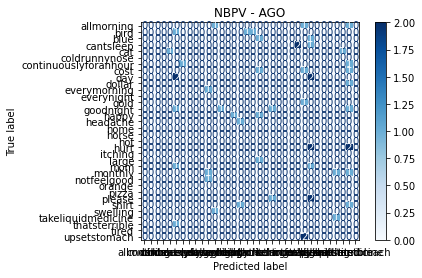

        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
45   0.135028 -0.143245 -0.135879  ...   0.539474   0.539474   0.539474
132  0.222031 -0.235542 -0.218383  ...   0.724771   0.706422   0.706422
16   0.128388   -0.1362 -0.120442  ...   0.630435   0.619565   0.597826
26   0.168371 -0.178616 -0.170415  ...   0.359375   0.359375   0.359375
97   0.215953 -0.229093 -0.215778  ...   0.492063    0.47619    0.47619
..        ...       ...       ...  ...        ...        ...        ...
116  0.208217 -0.220887 -0.184646  ...   0.372881   0.372881   0.372881
58   0.154434 -0.163832 -0.151897  ...   0.101695   0.101695   0.101695
13   0.200139 -0.212317 -0.200131  ...  0.0526316  0.0657895  0.0394737
89   0.199991 -0.212161 -0.200705  ...   0.671233   0.650685   0.636986
114  0.148327 -0.157353 -0.150834  ...   0.983146   0.983146   0.983146

[122 rows x 1700 columns]
5856


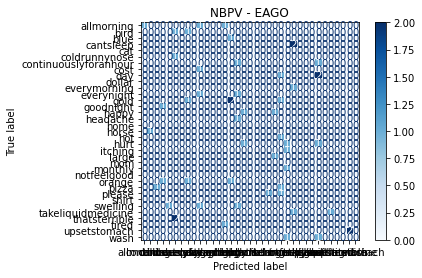

           EMG0L        EMG0L       EMG0L  ...      EMG7R       EMG7R      EMG7R
62     0.0147947    -0.015695  -0.0546728  ...  -0.073543   -0.178707  -0.448446
79     0.0429261   -0.0455382    -0.39625  ...   0.127518    0.277227 -0.0464942
156    0.0385735   -0.0409208 -0.00528484  ...  -0.126036     0.12816  0.0554324
96     0.0632527    0.0114731    -0.48606  ...   0.060971   -0.353161  -0.201941
140    0.0319524   -0.0338967   -0.147706  ... -0.0617425  0.00742775   0.146214
..           ...          ...         ...  ...        ...         ...        ...
89     0.0445367   -0.0472468   -0.109908  ...  -0.212587   -0.169915  -0.845454
32     0.0169961   -0.0180304   0.0270031  ...  -0.800004    0.140061  -0.577092
166 -0.000105485  0.000111904   -0.147575  ...  -0.803665     -1.2004 -0.0507544
136    0.0141584   -0.0150199  -0.0139257  ...    0.25523    0.203785   0.135111
26     0.0509993   -0.0541027   -0.125997  ...  -0.115725    0.718398   0.426949

[122 rows x 800 columns]
10

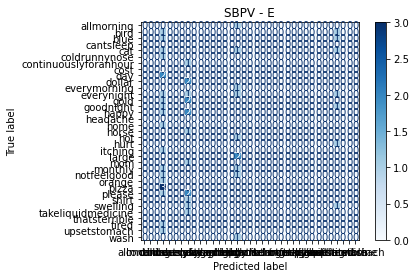

          AXL       AXL       AXL  ...      AZR       AZR       AZR
120  -1.09333  -1.05749 -0.685717  ...  1.54046   1.41773   1.39265
105  0.343857  0.359631  0.375407  ...  1.62661   1.19321    1.4041
68   -1.20628  -1.26022  -0.71004  ...  1.28986   1.29567   1.30148
76   0.527622  0.778737   1.12377  ...  1.22263   1.24636   1.25427
96  -0.833064 -0.635436 -0.278114  ...  1.10441   1.11235       1.1
..        ...       ...       ...  ...      ...       ...       ...
168 -0.917807  -1.05292 -0.993811  ...  1.22124   1.22884    1.1216
65  -0.536002 -0.507837 -0.522925  ...  1.28569   1.27362   1.23841
54   -1.69561  -1.94453  -1.66005  ...  1.06585  0.560534   1.03778
114  -1.20819  -1.23475  -1.31273  ...  1.05648   1.04277   1.10275
148  -1.41129    -1.395  -1.41673  ...  1.11684   1.06342  0.938463

[122 rows x 300 columns]
2928


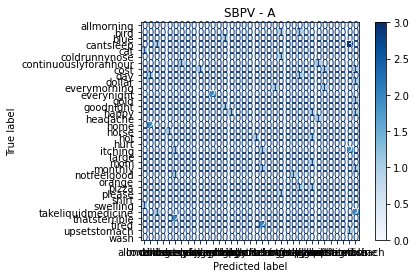

           GXL        GXL        GXL  ...        GZR         GZR         GZR
115  -0.677045  -0.431691   0.116205  ...    -0.1024  -0.0249198  -0.0304541
104  0.0983504  0.0330001   0.158163  ...  0.0407535   0.0451841   0.0396459
91   -0.043784 -0.0454723 -0.0167707  ...  -0.675218   -0.980805   -0.938596
63   -0.100569 -0.0861013  -0.050737  ...  -0.676042   -0.351334   -0.216306
5   -0.0470438  -0.118705 -0.0903107  ...   0.126024    0.170643    0.180108
..         ...        ...        ...  ...        ...         ...         ...
57   -0.240333  -0.110641   0.117991  ... -0.0117012 -0.00702157 -0.00434751
170  -0.489873   -0.53438  -0.307704  ... -0.0416955  -0.0644666  -0.0799924
171  -0.163585  -0.276678  -0.526063  ...   -1.09153   -0.958136    -0.78608
50    0.236875   0.176161  0.0439391  ... -0.0626481    -0.04241  -0.0612989
92  -0.0525297 -0.0773287  -0.108741  ...   0.663334     1.03532     0.92951

[122 rows x 300 columns]
4636


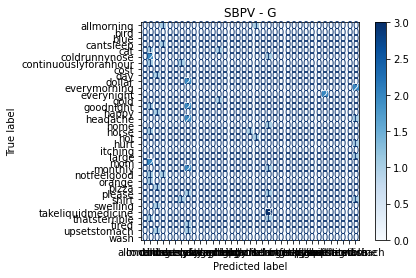

           ORL        ORL        ORL  ...        OYR        OYR        OYR
17   -0.502802  -0.502802  -0.502802  ...   0.276333   0.172449   0.120506
102 -0.0443615 -0.0443615  0.0275761  ...   -1.41117   -1.41117   -1.41117
36   -0.904322  -0.941924  -0.979526  ...   -1.01713   -1.01713   -1.01713
130  -0.458983  -0.458983  -0.458983  ...    1.78352    1.70147    1.67413
103   -0.78612   -0.78612   -0.78612  ...   -1.82734   -1.82734   -1.82734
..         ...        ...        ...  ...        ...        ...        ...
75    0.907191   0.947044   0.907191  ... -0.0492851 -0.0492851 -0.0492851
30   0.0157943  0.0157943  0.0157943  ...    1.56089    1.40638    1.25187
79   0.0729676  0.0064318  -0.060104  ...  0.0729676  0.0729676  0.0729676
60   0.0587304  0.0587304  0.0848328  ...   -1.82064   -1.82064   -1.82064
127  -0.957832  -0.957832  -0.957832  ...    1.91718    1.91718    1.89196

[122 rows x 300 columns]
1586


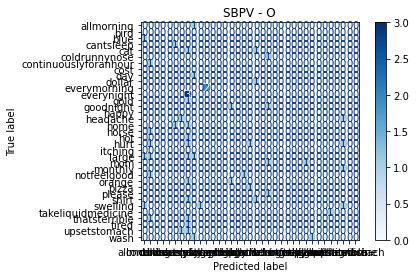

          EMG0L       EMG0L      EMG0L  ...       AZR       AZR       AZR
160 -0.00338798  0.00359414   0.296347  ...   1.02521   1.29933   1.45747
42    0.0995484   -0.105606 -0.0979126  ...   1.08417   1.07912  0.966404
135   0.0441858  -0.0468746  -0.104882  ...  0.812299  0.662185  0.781062
103   0.0478847  -0.0507985   -0.32469  ...  0.940302  0.946357  0.971443
52    0.0430321  -0.0456507  -0.042325  ...   1.29882    1.3119   1.28387
..          ...         ...        ...  ...       ...       ...       ...
95    0.0203429  -0.0215808 -0.0835803  ...   1.07264    1.0123  0.967994
120   0.0176462    -0.01872 -0.0564615  ...   1.54046   1.41773   1.39265
154  0.00362229 -0.00384271 -0.0251884  ...   1.69417   1.66515   1.38741
130   0.0411836  -0.0436896  -0.132026  ...    1.1451   1.44443   1.67795
21    0.0197615   -0.020964 -0.0445706  ...   1.39503    1.3513   1.38111

[122 rows x 1100 columns]
10980


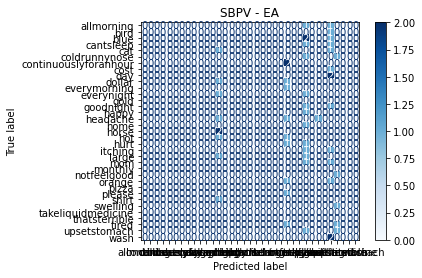

         EMG0L      EMG0L      EMG0L  ...         GZR         GZR         GZR
5    0.0214954 -0.0228035 -0.0438887  ...    0.126024    0.170643    0.180108
51   0.0577321 -0.0612452  -0.022265  ...   -0.187205  -0.0587555  0.00546946
30   0.0442405 -0.0469326  -0.680941  ...   -0.941029    -1.88275    -2.33958
136  0.0141584 -0.0150199 -0.0139257  ...    -2.78731    -2.35644    -2.28142
119  0.0444738 -0.0471801   0.175205  ...   -0.112505    -0.14045   -0.102686
..         ...        ...        ...  ...         ...         ...         ...
7    0.0200739 -0.0212954  -0.462388  ...  -0.0941719   -0.216255   -0.477862
96   0.0632527  0.0114731   -0.48606  ...  -0.0531872  -0.0515342  -0.0333505
91    0.019366 -0.0205445 -0.0401264  ...   -0.675218   -0.980805   -0.938596
11   0.0565648 -0.0600069  -0.497548  ...  0.00771866  0.00771866  0.00771866
107  0.0325368 -0.0345167    0.17505  ...     1.57025     1.12591     1.06352

[122 rows x 1100 columns]
10980


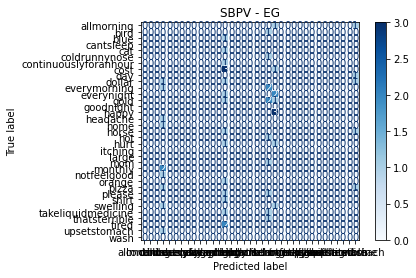

          EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
100   0.0430082  -0.0456253  -0.220882  ...  -1.52825  -1.52825  -1.52825
129   0.0275633  -0.0292406 -0.0476993  ...  -2.02609  -2.02609  -2.02609
102    0.020853  -0.0221219  -0.168798  ...  -1.41117  -1.41117  -1.41117
44    0.0437319  -0.0463931 -0.0139556  ...   0.96661   0.96661   0.96661
138    0.027736  -0.0294237  -0.179955  ...  0.654992  0.240939 -0.113963
..          ...         ...        ...  ...       ...       ...       ...
30    0.0442405  -0.0469326  -0.680941  ...   1.56089   1.40638   1.25187
97     0.049485  -0.0524962  -0.126524  ... -0.321221 -0.376956 -0.376956
70   0.00927839 -0.00984299  0.0661043  ...   1.53462   1.46197   1.42564
135   0.0441858  -0.0468746  -0.104882  ...     1.978   2.00466   2.00466
72   -0.0109027   0.0115662    0.13975  ...  -1.97271  -1.97271  -1.97271

[122 rows x 1100 columns]
10614


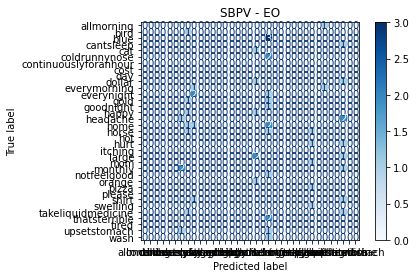

          AXL       AXL       AXL  ...        GZR          GZR         GZR
113   -0.6053 -0.594109 -0.610463  ... -0.0331169    0.0615197  -0.0831137
146 -0.889831 -0.932742  -0.88344  ...  -0.051151   -0.0617371  -0.0496387
116  -1.11737  -1.19429  -1.27121  ...  -0.442319    -0.232189   0.0333589
141  0.529547  0.748987   1.29962  ...  -0.620926    -0.565424   -0.520013
94   0.839235  0.844154  0.809715  ...  -0.399772    -0.673839   -0.815599
..        ...       ...       ...  ...        ...          ...         ...
67   -1.37293  -1.36424  -1.43289  ... -0.0524578   -0.0550425  -0.0515963
2    -1.57923  -1.53296  -1.21255  ...  0.0550929 -0.000272008  0.00441994
51   -1.29829  -1.13009 -0.610544  ...  -0.187205   -0.0587555  0.00546946
78   -1.40665   -1.4148  -1.43823  ...   -1.04363    -0.936696   -0.712613
147  -1.52435   -1.5299  -1.51419  ...  -0.334779    -0.178567   -0.392457

[122 rows x 600 columns]
5246


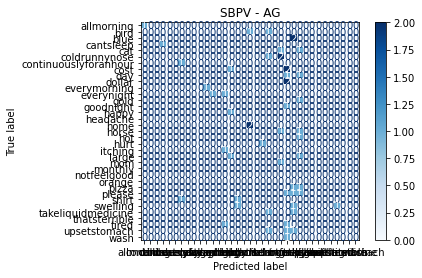

          AXL       AXL       AXL  ...        OYR        OYR        OYR
144  -1.43198  -1.51625  -1.56476  ...   0.372031   0.372031   0.372031
128 -0.398758 -0.426308 -0.419421  ...    1.91289    1.91289    1.88793
96  -0.833064 -0.635436 -0.278114  ...  -0.375947  -0.375947  -0.375947
76   0.527622  0.778737   1.12377  ...  -0.186387  -0.186387  -0.186387
169 -0.988909 -0.988909 -0.984658  ...   -1.76789   -1.89845   -1.97678
..        ...       ...       ...  ...        ...        ...        ...
62  -0.898454 -0.872454 -0.924456  ...  -0.702459  -0.702459  -0.702459
120  -1.09333  -1.05749 -0.685717  ...    -0.3357    -0.3357    -0.3357
118  -1.62663  -1.64721  -1.73931  ...   0.941585   0.877503   0.941585
51   -1.29829  -1.13009 -0.610544  ... -0.0523166 -0.0523166 -0.0523166
29   -1.33169  -1.28392  -1.31292  ...   -1.52449   -1.52449   -1.52449

[122 rows x 600 columns]
2806


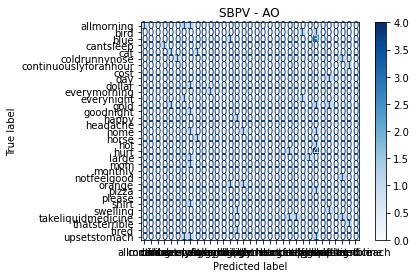

           GXL        GXL        GXL  ...        OYR        OYR        OYR
56  -0.0542186  -0.474507   0.618609  ...   0.202434   0.202434   0.202434
2   -0.0593905   0.151747  -0.224547  ...    -1.8653    -1.8653    -1.8653
173  -0.247267  -0.453039  -0.328329  ...  -0.956788  -0.956788  -0.956788
57   -0.240333  -0.110641   0.117991  ...   -1.23814   -1.23814   -1.23814
122 -0.0464312 -0.0464312 -0.0160746  ...  -0.435544   -0.49084  -0.546135
..         ...        ...        ...  ...        ...        ...        ...
64  -0.0467539 -0.0767813  -0.083454  ...    1.48616    1.48616    1.45821
105  -0.188409 -0.0425515  0.0303771  ...    2.09356   -2.47126   -2.36693
14   0.0247393 -0.0423339 -0.0608034  ...  -0.746361  -0.666049  -0.625894
96     2.94547    2.26192    2.40904  ...  -0.375947  -0.375947  -0.375947
157   -0.14745 -0.0941191 -0.0955225  ... -0.0132354 -0.0132354 -0.0132354

[122 rows x 600 columns]
4514


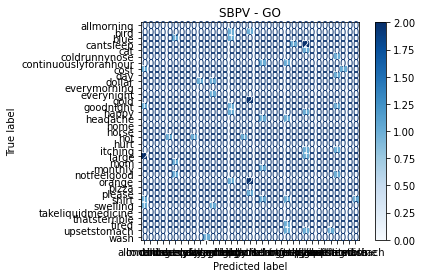

          EMG0L       EMG0L      EMG0L  ...         GZR        GZR        GZR
44    0.0437319  -0.0463931 -0.0139556  ...   0.0294262 -0.0132207  0.0163041
84    0.0507245  -0.0538111  -0.146624  ...    -1.39257   -1.21162  -0.934741
52    0.0430321  -0.0456507  -0.042325  ...   -0.110845  -0.058134 -0.0490458
112   0.0390422  -0.0414179 -0.0384006  ...   -0.975924  -0.673824  -0.207969
4     0.0224911  -0.0238597  -0.262829  ...   -0.145145 -0.0920999  -0.273229
..          ...         ...        ...  ...         ...        ...        ...
107   0.0325368  -0.0345167    0.17505  ...     1.57025    1.12591    1.06352
16   0.00795033 -0.00843412  0.0535333  ...    -2.67535   -2.02622   -1.83355
27    0.0374115   -0.039688  0.0629673  ...     -0.0719 -0.0205632 -0.0181186
93    0.0199706  -0.0211859 -0.0196425  ...  0.00376636  -0.362045  -0.525775
63    0.0359372   -0.038124 -0.0628059  ...   -0.676042  -0.351334  -0.216306

[122 rows x 1400 columns]
10980


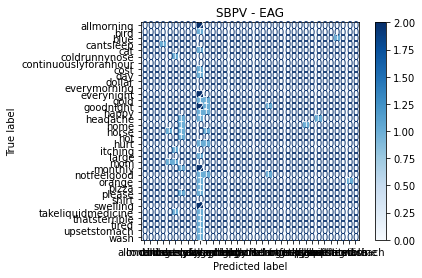

         EMG0L      EMG0L      EMG0L  ...       OYR       OYR       OYR
48   0.0561488 -0.0595655 -0.0552262  ...     2.045   2.01787   1.99074
19   0.0142664 -0.0151346   0.677674  ...  -1.56473  -1.56473  -1.56473
101  0.0315697 -0.0334908  -0.139445  ...  -1.49408  -1.56028  -1.56028
89   0.0445367 -0.0472468  -0.109908  ...  0.616572  0.544552  0.496538
29   0.0349163  -0.037041   -0.14275  ...  -1.52449  -1.52449  -1.52449
..         ...        ...        ...  ...       ...       ...       ...
174   0.028251 -0.0299701 -0.0658352  ...   2.12477   2.09796   2.09796
99   0.0237443 -0.0251891  0.0910761  ...   1.86092   1.86092   1.86092
94   0.0122775 -0.0130246 -0.0912854  ...  -1.80304  -1.80304   2.12154
111  0.0562284   -0.05965  -0.202547  ...   1.09242   1.09242   1.09242
104  0.0367521 -0.0389886  -0.100204  ... -0.483528 -0.483528 -0.483528

[122 rows x 1400 columns]
10492


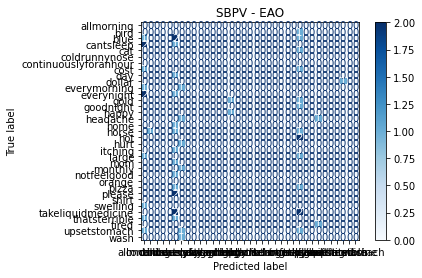

          EMG0L      EMG0L      EMG0L  ...        OYR        OYR        OYR
138    0.027736 -0.0294237  -0.179955  ...   0.654992   0.240939  -0.113963
21    0.0197615  -0.020964 -0.0445706  ... -0.0448906 -0.0448906 -0.0448906
109  0.00740057 -0.0078509  0.0292671  ...    2.03727    2.00964      1.982
171  -0.0264624  0.0280726    0.33063  ...    -1.6275    -1.6538   -1.70642
136   0.0141584 -0.0150199 -0.0139257  ...    2.50367    2.39718    2.31731
..          ...        ...        ...  ...        ...        ...        ...
63    0.0359372  -0.038124 -0.0628059  ...    1.45712    1.45712    1.43065
167   0.0192383  -0.020409   0.112809  ...   0.932512   0.672215   0.476993
15    0.0358144  -0.233197   0.150166  ...   0.232595   0.232595   0.232595
142  -0.0138065  0.0146466 -0.0448606  ...    2.47877    2.35494    2.28065
135   0.0441858 -0.0468746  -0.104882  ...      1.978    2.00466    2.00466

[122 rows x 1400 columns]
10614


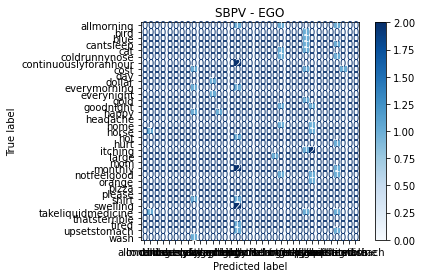

          AXL       AXL       AXL  ...        OYR        OYR        OYR
123  -1.50938  -1.51767   -1.5278  ...  -0.899395  -0.899395  -0.845848
151 -0.705226 -0.624393 -0.506904  ...   0.652709   0.652709   0.652709
156  -1.11864  -1.10653  -1.02779  ...   0.440973    0.38691    0.38691
106  0.611563  0.408966  0.534971  ...   -2.38524   -2.35908   -2.33292
79   -1.52444  -1.13545  -1.04866  ...  0.0729676  0.0729676  0.0729676
..        ...       ...       ...  ...        ...        ...        ...
121 -0.779256  -0.75963 -0.774584  ...   0.460779 -0.0594833  -0.423667
33   -2.07348  -2.00202  -1.35675  ...   -1.48986   -1.53385   -1.55585
103  -1.36157  -1.37281  -1.43164  ...   -1.82734   -1.82734   -1.82734
101  -1.11017  -1.03679  -1.12166  ...   -1.49408   -1.56028   -1.56028
13  -0.843122 -0.860139 -0.784771  ...   -1.03014  -0.987212   -1.07307

[122 rows x 900 columns]
4636


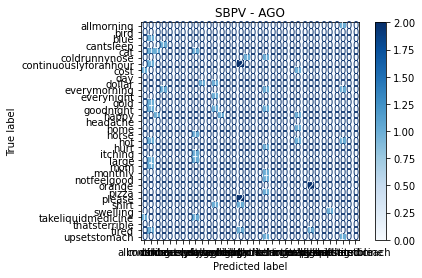

          EMG0L       EMG0L       EMG0L  ...        OYR        OYR        OYR
151   0.0243899   -0.025874   -0.108092  ...   0.652709   0.652709   0.652709
35   0.00630009 -0.00668346     0.10681  ...   -2.13735   -2.13735   -2.13735
172   0.0288608   0.0910621   -0.522507  ...  0.0343046  0.0343046  0.0343046
10    0.0169929   -0.018027  -0.0577223  ...   -1.48877   -1.52993   -1.52993
60    0.0419923  -0.0445476   -0.145308  ...   -1.82064   -1.82064   -1.82064
..          ...         ...         ...  ...        ...        ...        ...
171  -0.0264624   0.0280726     0.33063  ...    -1.6275    -1.6538   -1.70642
153  -0.0117406    0.012455  -0.0592052  ...  -0.165227  -0.224027  -0.224027
58  -0.00524917  0.00556859  0.00516292  ...   -1.27985   -1.27985   -1.27985
77    0.0568731  -0.0603339   -0.353871  ... -0.0512781 -0.0512781 -0.0512781
27    0.0374115   -0.039688   0.0629673  ...  -0.819821  -0.872976  -0.872976

[122 rows x 1700 columns]
10614


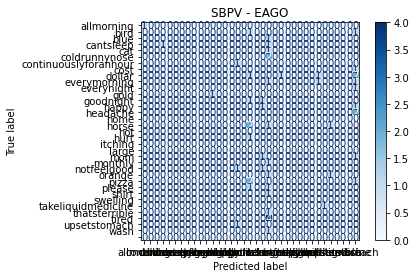

In [11]:
for st in steps:
  rownum+=1
  columnnum=-1
  for pr in regproducts:
    columnnum+=1
    combo=nsteps[rownum]+' - '+comb[columnnum]
    words=set(pr['Word']) # Obtain the target names for the SVM
    
    # First step: set input matrix as regular, normalized or standardized
    input_matrix=pr
    if st%3==0: # Normalization
      input_matrix=normproducts[columnnum]
    if st%5==0: # Standardization
      input_matrix=stanproducts[columnnum]
    
    # Second step: apply Butterworth
    two_matrix=input_matrix
    if st%7==0: # Butterworth
      two_matrix=butterworth(input_matrix)
    
    # Third step: split data for later steps
    x_train, x_test, y_train, y_test=datasplit(two_matrix)
    
    # Fourth step: apply PCA
    x_t_train=x_train
    x_t_test=x_test
    if st%11==0: # PCA
      x_train, x_test, y_train, y_test, x_t_train, x_t_test=pca(x_train, x_test, y_train, y_test)
    
    # Fifth step: apply SVM
    if st%13==0: # SVM
      #svmresults,accuracy,par=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
      svmresults,accuracy=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
    
    #print('The best parameters for',combo,'are:',par)
    fresults[rownum,columnnum]=accuracy*100
fresults=pd.DataFrame(fresults,index=nsteps,columns=comb)
exec("fresults.to_csv(path_or_buf='/content/results_'+str(numreps)+'.csv')")

endtime=time.time()

# **5. Results**

In [12]:
print(fresults)
print('The maximum accuracy for',numreps,'repetitions is',fresults.max().max())
print('The program executed in '+str(endtime-starttime)+' seconds')

             E          A          G  ...        EGO        AGO       EAGO
V     0.000000   8.400000   0.000000  ...   0.000000   0.000000   0.000000
NV    6.766667   2.200000   8.600000  ...   6.233333   6.233333   8.066667
SV    0.000000   0.000000   8.066667  ...   0.000000   8.233333   0.000000
BV    0.166667   2.366667   0.000000  ...   2.200000   2.200000   0.000000
PV    1.833333  19.066667   6.400000  ...   0.000000   0.000000  14.833333
NBV   0.000000   0.000000   0.000000  ...   4.566667  10.433333   0.000000
NPV   0.000000   5.866667  10.633333  ...   8.066667   1.833333   7.333333
SBV   2.200000   2.000000   0.000000  ...   4.200000   6.566667   0.000000
SPV   4.400000   4.566667   4.566667  ...   2.000000  12.466667  10.266667
BPV   8.433333   3.666667   4.400000  ...   6.233333   6.600000  10.633333
NBPV  0.000000   6.600000   4.400000  ...  10.266667   8.800000   2.200000
SBPV  2.366667  22.000000   6.600000  ...   0.000000   4.400000  11.000000

[12 rows x 15 columns]
T